# GravelRiverTransporter

This notebook describes the `GravelRiverTransporter` component and its underlying theory, and provides some simple examples of usage.

## Overview

`GravelRiverTransporter` is a Landlab component for modeling landscape evolution in the context of a network of gravel-bed alluvial channels. The component is meant to operate in conjunction with a single-direction flow routing scheme, such that each grid cell drains to one and only one of its neighbors. Channels are assumed to be sub-grid-scale features with a bankfull channel width that adjusts according to the local discharge, slope, and grain diameter. The approach follows that of Wickert & Schildgen (2019), but with two additions:

1. Because the channel network is calculated from, and embedded within, a topographic field represented as a 2d grid, conservation of mass is calculated on the basis of individual grid cells rather than using a prescribed valley width.

2. The component adds progressive loss of gravel load due to abrasion; the lost material is assumed to become part of the suspended and/or wash load, which is not explicitly tracked.

The theory that channels with gravel bed and bank materials tend to adjust their shear stress ratio dates back to Parker (1978), and a variety of studies have supported the idea for gravel rivers. Phillips and Jerolmack (2016) argued that the concept may also be applicable to some "bedrock" rivers as well (the question depends somewhat on the definition of "bedrock river", but presumably a river that is capable of eroding into bedrock but that also has at least one self-formed bank made of alluvial material would qualify as self-adjusting).

## Theory

### Channel-width adjustment

We treat only the coarse, bed-load fraction. We assume that channel width adjusts so as to ensure that bankfull shear stress is slightly larger (by a fraction $\epsilon$) than critical shear stress for the median sediment diameter. Wickert & Schildgen (2019) show that when this is the case, the channel tends to adjust such that its bankfull width depends on bankfull discharge, $Q$, channel gradient, $S$, and the median diameter of sediment on the bed, $D$, as follows: 

$$b = k_b \frac{QS^{7/6}}{D^{3/2}}$$

where $k_b$ is a factor given by:

$$k_b = 0.17 g^{-1/2} \left[ \left(\frac{\rho_s-\rho}{\rho}\right)(1+\epsilon )\tau_c^*\right]^{-5/3}$$

where $g$ is gravitational acceleration, $\rho_s$ is sediment grain density, $\rho$ is water density, $\epsilon$ is the ratio of bankfull to critical shear stress, and $\tau_c^*$ is the critical Shields stress (i.e., dimensionless critical shear stress). Using $g=9.8$ m/s$^2$, $\rho_s=2,650$ kg/m$^3$, $\rho=1,000$ kg/m$^3$, $\epsilon=0.2$, and $\tau_c^*=0.0495$, the value of $k_b$ is approximately 2.61 s/m$^{1/2}$ (as calculated below).

In [9]:
g = 9.8  # gravitational acceleration, m/s2
rhos = 2650.0  # sediment density, kg/m3
rho = 1000.0  # water density, kg/m3
eps = 0.2  # shear stress ratio
taustarc = 0.0495  # critical Shields stress (here from Wong & Parker (2006))

kb = 0.17 * g**(-0.5) * (((rhos - rho) / rho) * (1 + eps) * taustarc)**(-5./3.)
print('kb =', kb, 'seconds per square-root meter')
print('kb =', kb / (3600 * 24 * 365.25), 'years per square-root meter')

kb = 2.6064650240601455 seconds per square-root meter
kb = 8.259389256661297e-08 years per square-root meter


For example, the width of a channel with 1 cm diameter sediment on the bed, a 1% gradient, and a bankfull discharge with 1 cms discharge would be:

In [6]:
D = 0.01  # grain diameter, m
Q = 1.0  # bankfull discharge, m3/s
S = 0.01  # slope gradient, m/m
print("b = " + str(kb * Q * S**(7./6.) / D**1.5), 'meters')

b = 12.098138950879829 meters


Note that one aspect of the above width theory that may limit its applicability is the prediction that width should *increase* when slope increases. To appreciate where this comes from, recall that boundary shear stress in a relatively wide channel is proportional to the depth-slope product. All else equal, for a fixed shear stress, a steeper channel should be shallower and vice versa. For a given discharge, a shallower channel must either be wider or have faster flow, or both. So the prediction is logically and mathematically consistent. However, it neglects potential variations in roughness, and in particular the possibility that steeper channels might become rougher as the flow increases toward criticality (as suggested by Gordon Grant in a famous 1997 paper). The theory outlined here does not attempt to account for this effect, but users of the component should be aware of this limitation. In addition, the underlying treatment of shear stress as proportional to depth times slope is not appropriate for channels with a relatively small width-depth ratio; the component does not include any checks on this, so the user should be alert to unrealistic behavior when the calculated channel width is rather narrow.

### Gravel transport rate

We follow Wickert and Schildgen (2019) in using the Meyer-Peter Mueller equation for bed-load transport. When combined with the width-closure equation above, the predicted gravel transport rate is:

$$Q_s = k_Q I Q S^{7/6}$$

where $k_Q$ is a dimensionless transport efficiency factor equal to $\approx 0.041$. The variable $I$ is an efficiency factor, defined as the fraction of time that bankfull discharge occurs. In other words, one of the simplifications of the model is that the channel has two states: for a small fraction of the year, flow is equal to bankfull; for the rest of the time, the flow is too low to move any sediment.

To get a sense for what the transport law implies about rates, consider a case in which $Q = 1$ cms, $S = 0.01$, and bankfull flow occurs for 1% of the year:

In [8]:
Qs = 0.041 * 0.01 * 1 * (0.01)**(7./6.)
print("Qs", Qs, "cms")
print("Qs", Qs * 3600 * 24 * 265.25, "cubic meters per year")

Qs 1.903051421781239e-06 cms
Qs 43.61337126381372 cubic meters per year


This implies that 1 cms on a slope of 0.01 would carry about $2 \times 10^{-6}$ cms of sediment, or about 44 cubic meters in a given year.

### Gravel abrasion

The component uses a Sternberg-like method to calculate the downstream loss of mass to abrasion. The abrasion model is inspired by Attal & Lave (2006). We assume that the rate of loss of gravel mass to finer material per unit transport distance, $A$, is proportional to the gravel transport rate, $Q_s$:

$$A = \beta Q_s$$

where $\beta$ is an abrasion coefficient with units of inverse length.

To appreciate the implication of this treatment, consider a reach of channel with an incoming gravel load $Q_0$ at the head of the reach, and no inputs along the reach itself. The rate of change of gravel load with respect to downstream distance, $x$, is:

$$\frac{dQ_s}{dx} = -\beta Q_s$$

Integrating downstream from the head of the reach $x=0$, where $Q_s=Q_0$, 

$$Q_s = Q_0 e^{-\beta x}$$

In other words, one obtains a Sternberg-like profile, except here expressed in terms of remaining gravel load rather than median size.

## Tests for a prototype component

In [5]:
import numpy as np
from landlab import Component, RasterModelGrid, imshow_grid
from landlab.components import GravelRiverTransporter, FlowAccumulator
from landlab.plot.drainage_plot import drainage_plot
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

/Users/gtucker/opt/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [6]:
# Unit test for calc_transport_capacity
#   First, the predicted solution
dx = 100.0
slope = 0.01
discharge = 1.0 * dx * dx
trans_coef = 0.041
intermittency_fac = 0.01
predicted_outflux = trans_coef * intermittency_fac * discharge * slope ** (7.0 / 6.0)
print("Predicted outflux", predicted_outflux, "m3/y")

#   Next, the component-computed solution
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator

grid = RasterModelGrid((3, 3), xy_spacing=100.0)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[3:] = 1.0
fa = FlowAccumulator(grid)
fa.run_one_step()
transporter = GravelRiverTransporter(grid)
# transporter._receiver_node[4]
transporter.calc_transport_capacity()
print("Computed outflux ", transporter._sediment_outflux[4], "m3/y")
print("Rounded outflux  ", round(transporter._sediment_outflux[4], 7))

Predicted outflux 0.019030514217812388 m3/y
Computed outflux  0.0190305142178 m3/y
Rounded outflux   0.0190305


In [7]:
# Unit test for calc_sediment_rate_of_change
#   First, the predicted solution
dx = 100.0
slope = 0.01
discharge = 1.0 * dx * dx
trans_coef = 0.041
intermittency_fac = 0.01

flux = trans_coef * intermittency_fac * discharge * slope ** (7.0 / 6.0)
outflux_cores_and_open_bdy = np.array([0.0, 2 * flux, flux])
influx_cores_and_open_bdy = np.array([2 * flux, flux, 0.0])
predicted_dzdt_cores_open_bdy = (influx_cores_and_open_bdy - outflux_cores_and_open_bdy) / (dx * dx)
predicted_dzdt_cores_open_bdy[0] = 0.0

#   Next, the component-computed solution
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator

grid = RasterModelGrid((3, 4), xy_spacing=100.0)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[4] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = slope * grid.x_of_node

fa = FlowAccumulator(grid)
fa.run_one_step()
transporter = GravelRiverTransporter(grid)

transporter.calc_sediment_rate_of_change()
print("Predicted outflux", outflux_cores_and_open_bdy, "m3/y")
print("Computed outflux ", transporter._sediment_outflux[4:7], "m3/y")
print("Predicted influx", influx_cores_and_open_bdy, "m3/y")
print("Computed influx ", transporter._sediment_influx[4:7], "m3/y")
print("Predicted dzdt", predicted_dzdt_cores_open_bdy, "m/y")
print("Calculated dzdt", transporter._dzdt[4:7], "m/y")

Predicted outflux [ 0.          0.03806103  0.01903051] m3/y
Computed outflux  [ 0.          0.03806103  0.01903051] m3/y
Predicted influx [ 0.03806103  0.01903051  0.        ] m3/y
Computed influx  [ 0.03806103  0.01903051  0.        ] m3/y
Predicted dzdt [  0.00000000e+00  -1.90305142e-06  -1.90305142e-06] m/y
Calculated dzdt [  0.00000000e+00  -2.92777142e-06  -2.92777142e-06] m/y


In [8]:
# Unit test for run_one_step
#   First, the predicted solution
dx = 100.0
slope = 0.01
discharge = 1.0 * dx * dx
trans_coef = 0.041
intermittency_fac = 0.01
porosity = 0.35
dt = 1000.0  # time step, years

flux = trans_coef * intermittency_fac * discharge * slope ** (7.0 / 6.0)
outflux_cores_and_open_bdy = np.array([0.0, 2 * flux, flux])
influx_cores_and_open_bdy = np.array([2 * flux, flux, 0.0])
predicted_dzdt_cores_open_bdy = (1.0/(1.0-porosity))*(influx_cores_and_open_bdy - outflux_cores_and_open_bdy) / (dx * dx)
predicted_dzdt_cores_open_bdy[0] = 0.0
predicted_z = np.array([0.0, 1.0, 2.0]) + dt * predicted_dzdt_cores_open_bdy

#   Next, the component-computed solution
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator

grid = RasterModelGrid((3, 4), xy_spacing=100.0)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[4] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = slope * grid.x_of_node

fa = FlowAccumulator(grid)
fa.run_one_step()
transporter = GravelRiverTransporter(grid)

transporter.run_one_step(dt)
print("Predicted z ", predicted_z, "m/y")
print("Calculated z", transporter._elev[4:7], "m")

Predicted z  [ 0.          0.99707223  1.99707223] m/y
Calculated z [ 0.          0.99707223  1.99707223] m


### Analytical solution for an equilibrium profile of one cell width

Consider a 1D system in equilibrium with a baselevel lowering rate $U$. From W&S eq B2:

$$\frac{\partial z}{\partial t} = U - \frac{\beta Q_s}{B} -\frac{1}{1-\lambda_p} \left( \frac{\partial (Q_s/B)}{\partial x} - \frac{Q_s}{B^2} \frac{\partial B}{\partial x}\right) = 0$$

In our case, we assume a constant width $B$ (which will be equal to one grid cell width), so the right-most term is zero. That leaves us with:

$$\frac{d Q_s}{d x} = (1-\lambda_p) U B - \beta Q_s$$

If $\beta=0$ (no abrasion/attrition), this just integrates to:

$$Q_s = (1-\lambda_p) U B x$$

To solve for equilibium slope, we set $Q_s$ equal to transport capacity and solve for $S$:

$$k_Q I Q S^{7/6} = (1-\lambda_p) U B x$$

For a basin of fixed width $B$, $Q=rBx$ where $r$ is bankfull runoff rate (and we're assuming equilibrium hydrology, i.e., uniform $r$). So:

$$S = \left( \frac{(1-\lambda_p) U}{k_Q I r} \right)^{6/7}$$

This is our first test condition.

In the general case, the governing equation has the form $dy/dx = a + by$. Integrating downstream from the headwaters, where $x=0$ and $Q_s=0$,

$$Q_s = \frac{(1-\lambda_p) U B}{\beta} \left( 1 - e^{-\beta x} \right)$$

It's a saturating exponential because at some point the rate of addition of gravel balances its rate of abrasion.

At any point $x$, the slope has to be just sufficient to carry the imposed $Q_s$ with the available discharge (and given the intermittency factor, $I$):

$$S(x) = \frac{(1-\lambda_p)U}{k_QIrx\beta} \left( 1 - e^{-\beta x}\right)$$

I think what's going on here is that there's a tradeoff between growing discharge downstream ($Q = rBx$, where $r$ is bankfull runoff rate) and growing sediment downstream (the saturating exponential). But ultimately the sediment load stops growing downstream, and the water effect takes over.

Predicted slope = 0.041458524071568
Computed slope = [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.04145835  0.04145836  0.04145837  0.04145838  0.0414584   0.04145841
  0.04145842  0.04145843  0.04145844  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
Pred outlfux [  100.   200.   300.   400.   500.   600.   700.   800.   900.  1000.]
Outflux [  99.99949608  199.99906893  299.99871268  399.9984218   499.99819101
  599.99801534  699.99789005  799.99781067  899.99777298    0.        ]


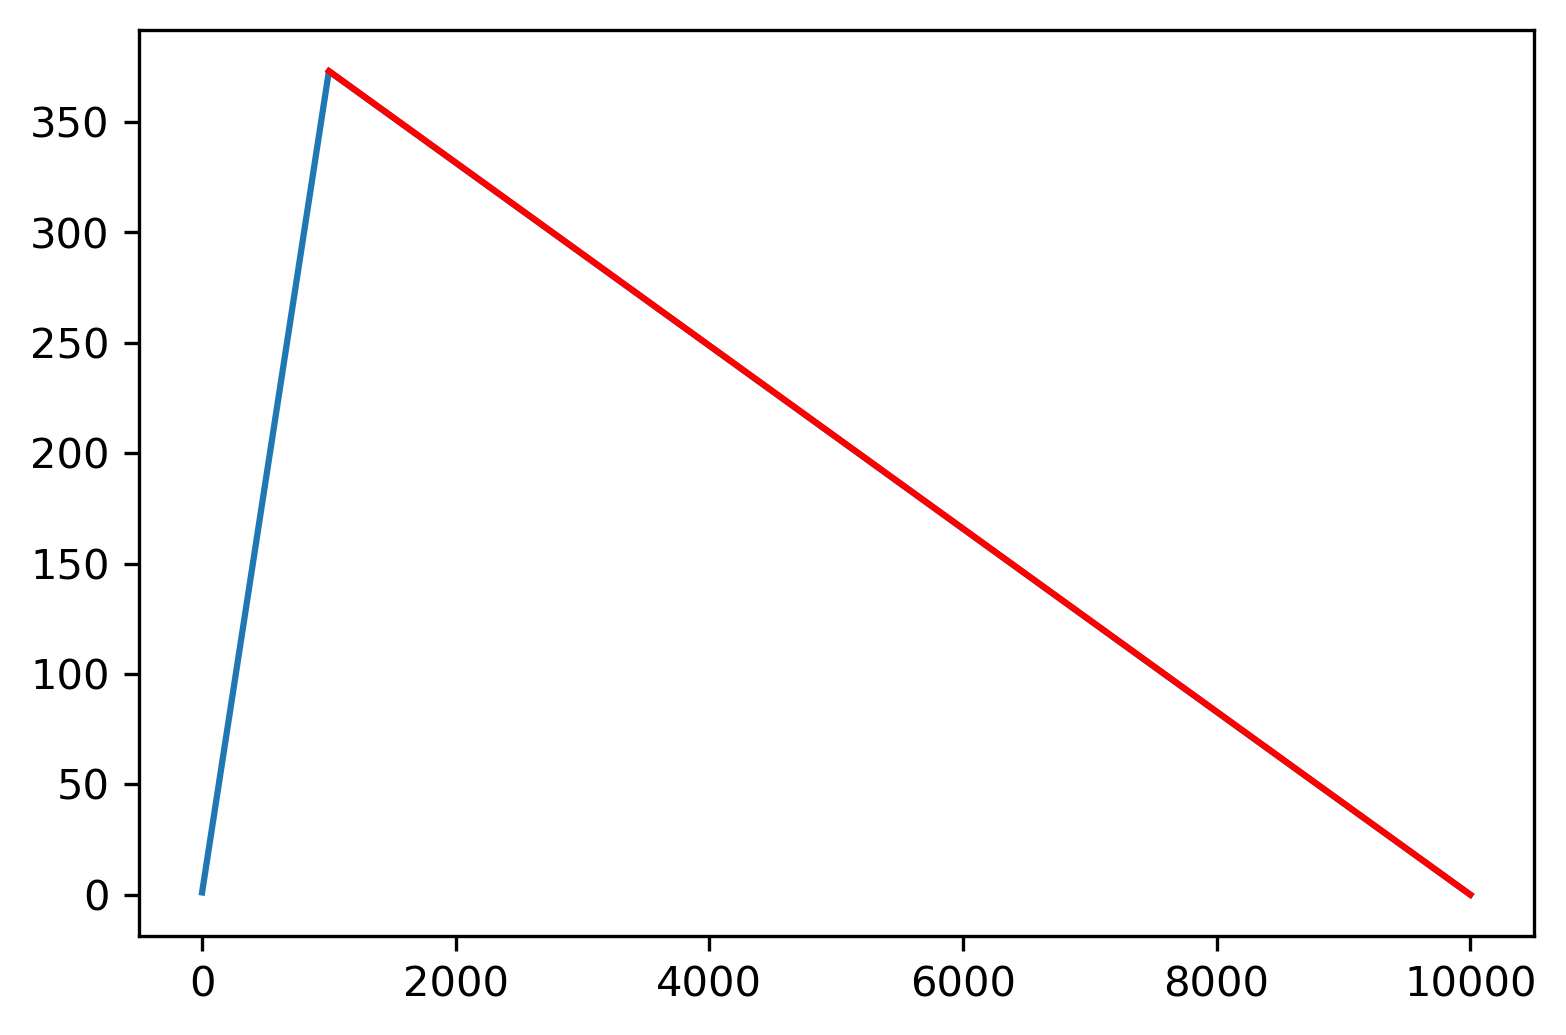

In [9]:
# Test for equilibrium with no abrasion
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
dt = 1000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.0  #0.35  # lambda_p
nsteps = 30000  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
poro_fac = 1.0 - porosity

# Grid setup
grid = RasterModelGrid((3, 11), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[21] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(grid, sediment_porosity=porosity)

for i in range(nsteps):
    elev[grid.core_nodes] += uplift_rate * dt
    fa.run_one_step()
    transporter.run_one_step(dt)
    
plt.plot(grid.x_of_node[11:22], elev[11:22])

# Analytical solution
xan = grid.x_of_node[12:22]
Spred = (
    (poro_fac * uplift_rate)
    / (trans_coef * intermittency_fac * bankfull_runoff_rate))**(6./7.)
zpred = Spred * (grid.x_of_node.max() - grid.x_of_node[12:22])
print('Predicted slope =', Spred)
print('Computed slope =', grid.at_node["topographic__steepest_slope"])
plt.plot(xan, zpred, 'r')
print('Pred outlfux', uplift_rate * dx * grid.x_of_node[12:22])
print('Outflux', transporter._sediment_outflux[12:22])

### Equilibrium with abrasion in just one cell

Input volume rate:

$$\text{input rate} = U\Delta x^2 (1-\lambda_p)$$

Output volume rate is abrasion loss rate plus outflux. The factor of 1/2 comes from calculating abrasion rate from the average of incoming sediment flux (which is zero in this case) and outgoing sediment flux:

$$\text{output rate} = \frac{1}{2}\beta Q_s \Delta x + Q_s = (1+\beta \Delta x/2) Q_s$$

Setting equal:

$$Q_s = \frac{U\Delta x^2 (1-\lambda_p)}{1+\beta \Delta x / 2}$$

The corresponding slope:

$$k_Q I Q S^{7/6} = \frac{U\Delta x^2 (1-\lambda_p)}{1+\beta \Delta x / 2}$$

$$S^{7/6} = \frac{U\Delta x^2 (1-\lambda_p)}{k_Q I Q (1+\beta \Delta x / 2)}$$

$$S = \left(\frac{U\Delta x^2 (1-\lambda_p)}{k_Q I r \Delta x^2 (1+\beta \Delta x / 2)}\right)^{6/7}$$

$$S = \left(\frac{U (1-\lambda_p)}{k_Q I r (1+\beta \Delta x/2)}\right)^{6/7}$$

The abrasion lowering rate:

$$E_a = \frac{\beta Q_s}{\Delta x} = \frac{\beta U\Delta x (1-\lambda_p)}{(1+\beta \Delta x / 2)}$$

In [10]:
# Test for equilibrium with abrasion in one cell
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
abrasion_length_scale = 2000.0  # this is the inverse of beta, in m
dt = 10000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.35  # lambda_p
nsteps = 200  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
abrasion_coef = 1.0 / abrasion_length_scale  # this is beta, 1/m
poro_fac = 1.0 - porosity

# Grid setup

grid = RasterModelGrid((3, 3), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[5] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abrasion_coef,
)

for i in range(nsteps):
    fa.run_one_step()
    elev[grid.core_nodes] += uplift_rate * dt
    transporter.run_one_step(dt)


In [11]:
# Compare with analytical solutions
Qs_pred = (uplift_rate * dx * dx * (1.0 - porosity)) / (abrasion_coef * dx / 2 + 1)
print('Predicted Qs', Qs_pred)
print('Computed Qs ', transporter._sediment_outflux[4])
S_pred = (Qs_pred / (trans_coef * intermittency_fac * bankfull_runoff_rate * dx * dx))**(6./7.)
print('Predicted S', S_pred)
print('Computed S ', transporter._slope[4])
Ea_pred = abrasion_coef * (Qs_pred / 2.0) / dx
print('Predicted Ea', Ea_pred)
print('Computed Ea ', transporter._abrasion[4])


Predicted Qs 52.0
Computed Qs  51.9970981699
Predicted S 0.02366944810159208
Computed S  0.0236683159314
Predicted Ea 1.3000000000000001e-05
Computed Ea  1.29992745425e-05


In [12]:
# Test for equilibrium with abrasion in two cells
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
abrasion_length_scale = 2000.0  # this is the inverse of beta, in m
dt = 10000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.35  # lambda_p
nsteps = 500  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
abrasion_coef = 1.0 / abrasion_length_scale  # this is beta, 1/m
poro_fac = 1.0 - porosity

# Grid setup

grid = RasterModelGrid((3, 4), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[7] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abrasion_coef,
)

for i in range(nsteps):
    fa.run_one_step()
    elev[grid.core_nodes] += uplift_rate * dt
    transporter.run_one_step(dt)


In [13]:
# Compare with analytical solutions in upper cell
Qs_pred = (uplift_rate * dx * dx * (1.0 - porosity)) / (abrasion_coef * dx / 2 + 1)
print('Predicted Qs', Qs_pred)
print('Computed Qs ', transporter._sediment_outflux[5])
S_pred = (Qs_pred / (trans_coef * intermittency_fac * bankfull_runoff_rate * dx * dx))**(6./7.)
print('Predicted S', S_pred)
print('Computed S ', transporter._slope[5])
Ea_pred = abrasion_coef * (Qs_pred / 2) / dx
print('Predicted Ea', Ea_pred)
print('Computed Ea ', transporter._abrasion[5])


Predicted Qs 52.0
Computed Qs  51.9999962748
Predicted S 0.02366944810159208
Computed S  0.0236694466482
Predicted Ea 1.3000000000000001e-05
Computed Ea  1.29999990687e-05


In [14]:
# Test for equilibrium with abrasion and 4 cells
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
abrasion_length_scale = 2000.0  # this is the inverse of beta, in m
dt = 10000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.35  # lambda_p
nsteps = 400  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
abrasion_coef = 1.0 / abrasion_length_scale  # this is beta, 1/m
poro_fac = 1.0 - porosity

# Grid setup

grid = RasterModelGrid((3, 6), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[11] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abrasion_coef,
)

for i in range(nsteps):
    fa.run_one_step()
    elev[grid.core_nodes] += uplift_rate * dt
    transporter.run_one_step(dt)


In [15]:
# Compare with analytical solutions in upper cell
Qs_pred = (uplift_rate * dx * dx * (1.0 - porosity)) / (abrasion_coef * dx / 2 + 1)
print('Predicted Qs', Qs_pred)
print('Computed Qs ', transporter._sediment_outflux[7])
S_pred = (Qs_pred / (trans_coef * intermittency_fac * bankfull_runoff_rate * dx * dx))**(6./7.)
print('Predicted S', S_pred)
print('Computed S ', transporter._slope[7])
Ea_pred = abrasion_coef * (Qs_pred / 2) / dx
print('Predicted Ea', Ea_pred)
print('Computed Ea ', transporter._abrasion[7])


Predicted Qs 52.0
Computed Qs  51.9922135808
Predicted S 0.02366944810159208
Computed S  0.023666410153
Predicted Ea 1.3000000000000001e-05
Computed Ea  1.29980533952e-05


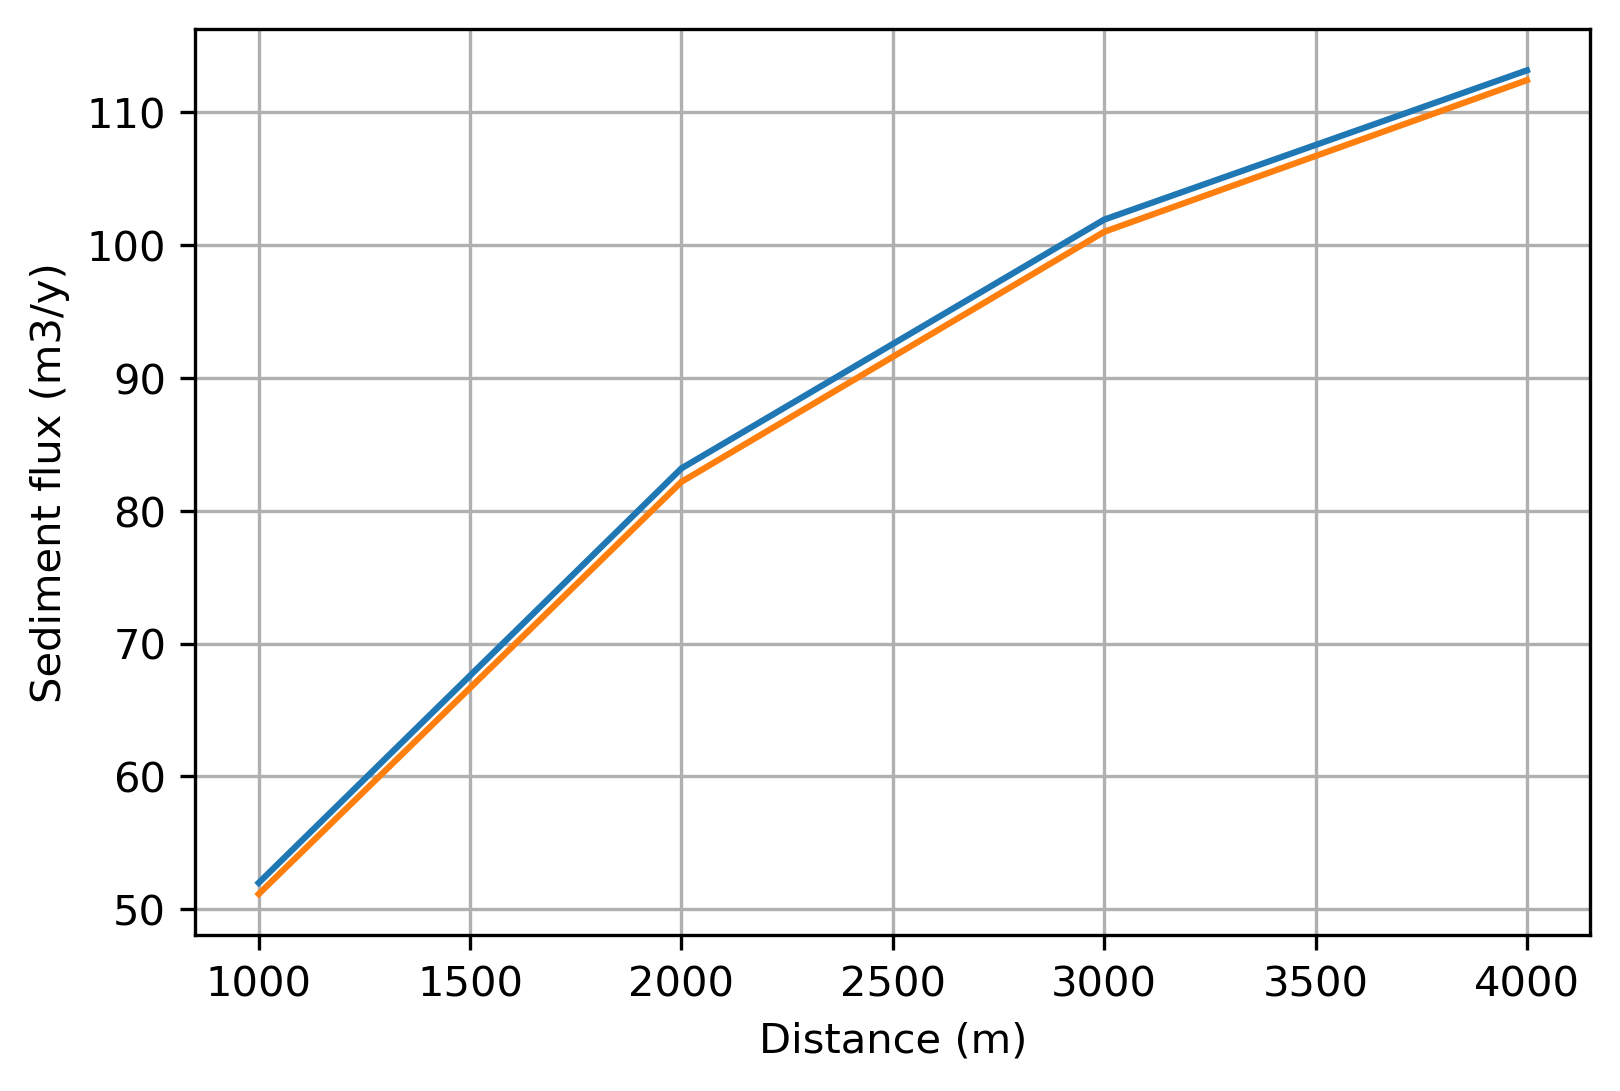

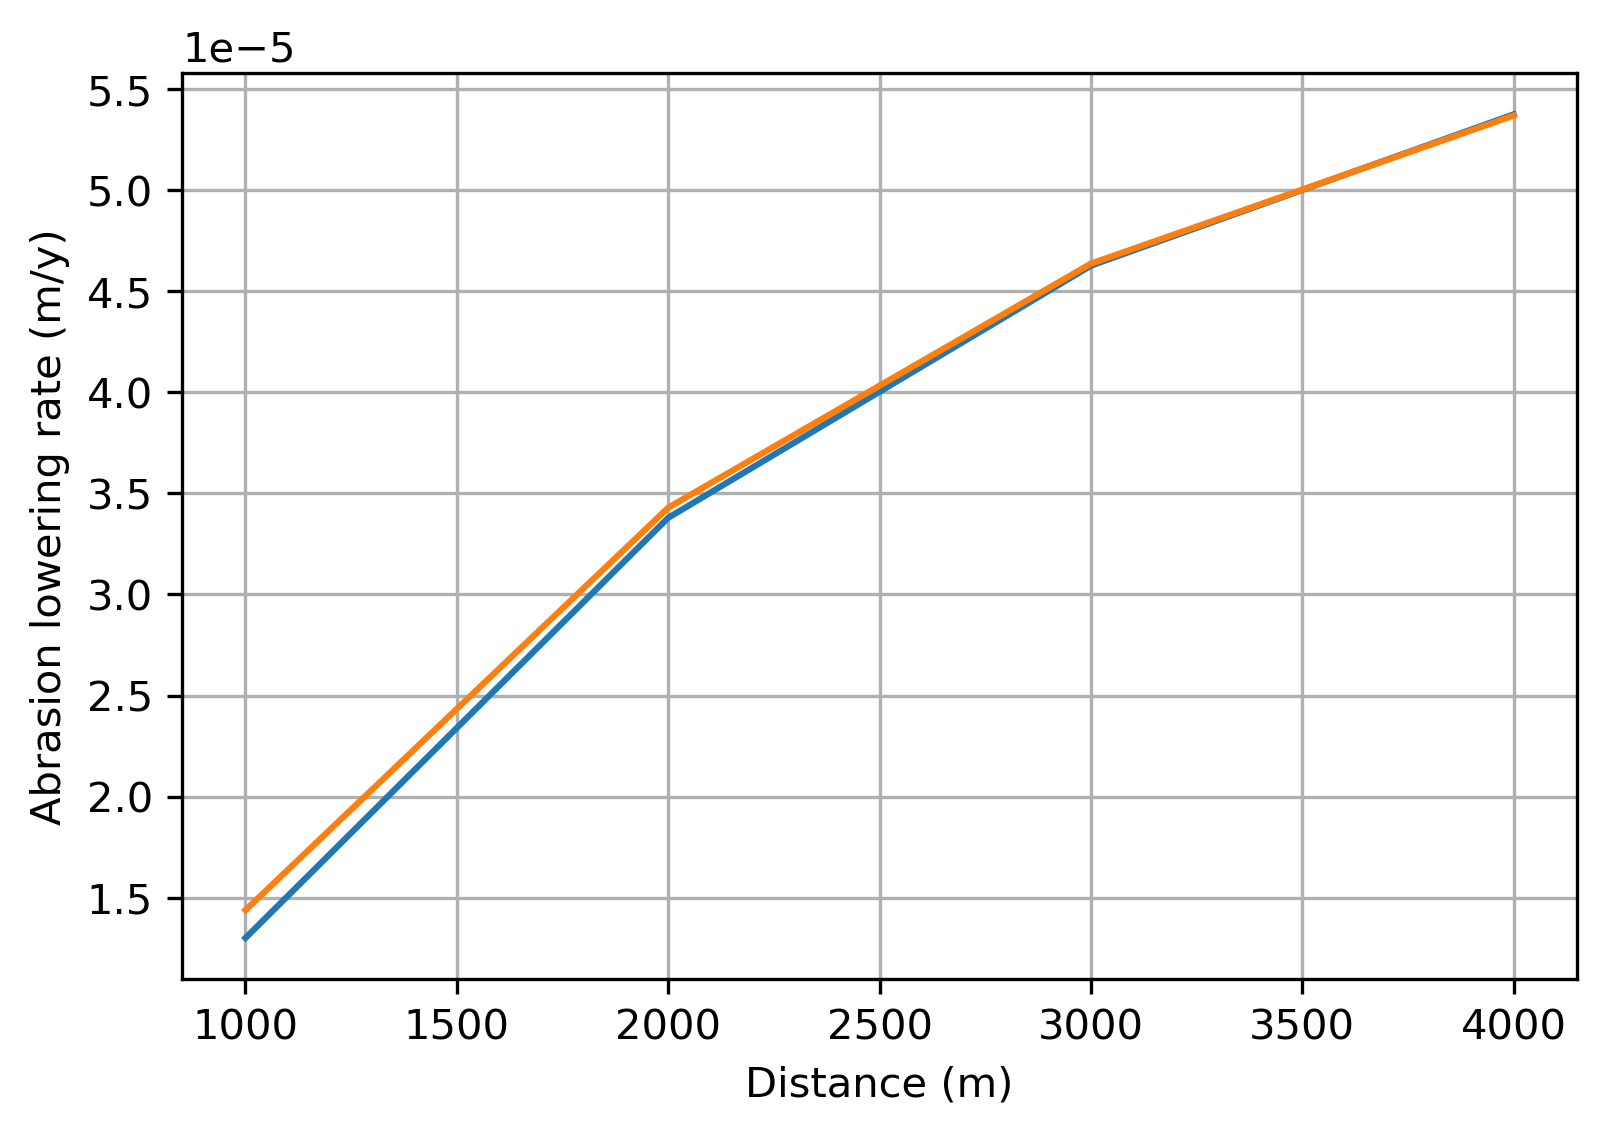

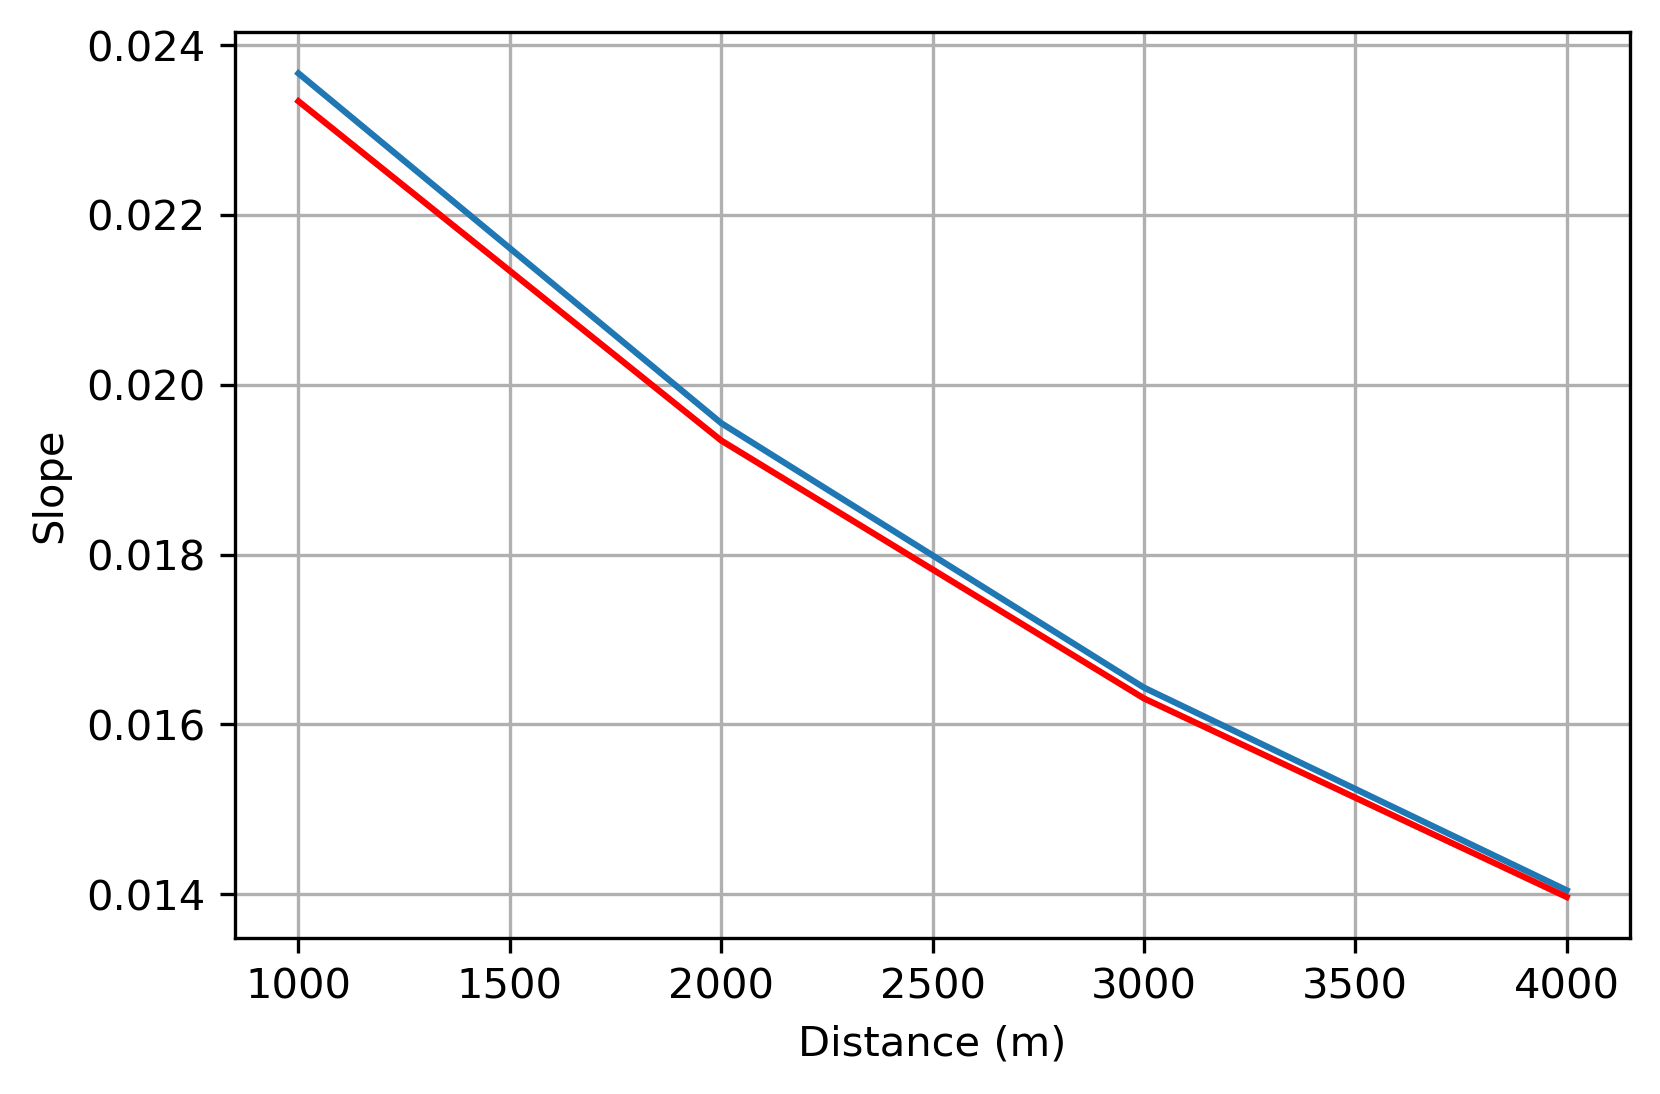

In [16]:
# Analytical solution for Qs
xan = grid.x_of_node[7:11]
Qs_analyt = (
    ((uplift_rate * dx * (1.0 - porosity)) / abrasion_coef)
    * (1.0 - np.exp(-abrasion_coef * xan)) 
)
plt.plot(xan, transporter._sediment_outflux[7:11])
plt.plot(xan, Qs_analyt)
plt.xlabel('Distance (m)')
plt.ylabel('Sediment flux (m3/y)')
plt.grid(True)

# Analytical solution for abrasion rate
Qs_analyt_nodes = (
    ((uplift_rate * dx * (1.0 - porosity)) / abrasion_coef)
    * (1.0 - np.exp(-abrasion_coef * (xan - 0.5 * dx))) 
)
abra = abrasion_coef * Qs_analyt_nodes / dx
plt.figure()
plt.plot(xan, transporter._abrasion[7:11])
plt.plot(xan, abra)
plt.xlabel('Distance (m)')
plt.ylabel('Abrasion lowering rate (m/y)')
plt.grid(True)

# Analytical solution for slope
plt.figure()
plt.plot(grid.x_of_node[7:11], transporter._slope[7:11])
Spred = (
    (((poro_fac * uplift_rate) 
     / (0.041 * 0.01 * bankfull_runoff_rate * xan * abrasion_coef)) 
    * (1.0 - np.exp(-abrasion_coef * xan)))**(6./7.)
)
plt.plot(xan, Spred, 'r')
plt.xlabel('Distance (m)')
plt.ylabel('Slope')
plt.grid(True)


## Playing with bigger scale

### Block-and-flat in 1D

In [17]:
# Parameters
dx = 1000.0
nrows = 3
ncols = 1601
init_elev_plateau = 100.0
noise_amp = 1.0
init_slope = 0.0001
abra_coef = 1.0 / 5000.0  # abrasion coefficient, 1/m
bf_runoff_rate = 10.0  # bankfull runoff rate, m/y
nsteps = 2000
dt = 100.0  # time step, y

In [18]:
# Grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
elev = grid.add_zeros("topographic__elevation", at="node")
elev[grid.x_of_node <= dx * ncols//2] += init_elev_plateau
xmax = np.amax(grid.x_of_node)
elev[:] += init_slope * (xmax - grid.x_of_node)
init_elev = elev.copy()

In [19]:
# Components
fa = FlowAccumulator(
    grid,
    runoff_rate=bf_runoff_rate,
    flow_director='FlowDirectorSteepest',
)
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abra_coef,
)

In [20]:
# Loop
import time

start = time.time()
for _ in range(nsteps):
    fa.run_one_step()
    transporter.run_one_step(dt)
print('Time:', time.time() - start)

Time: 9.183393001556396


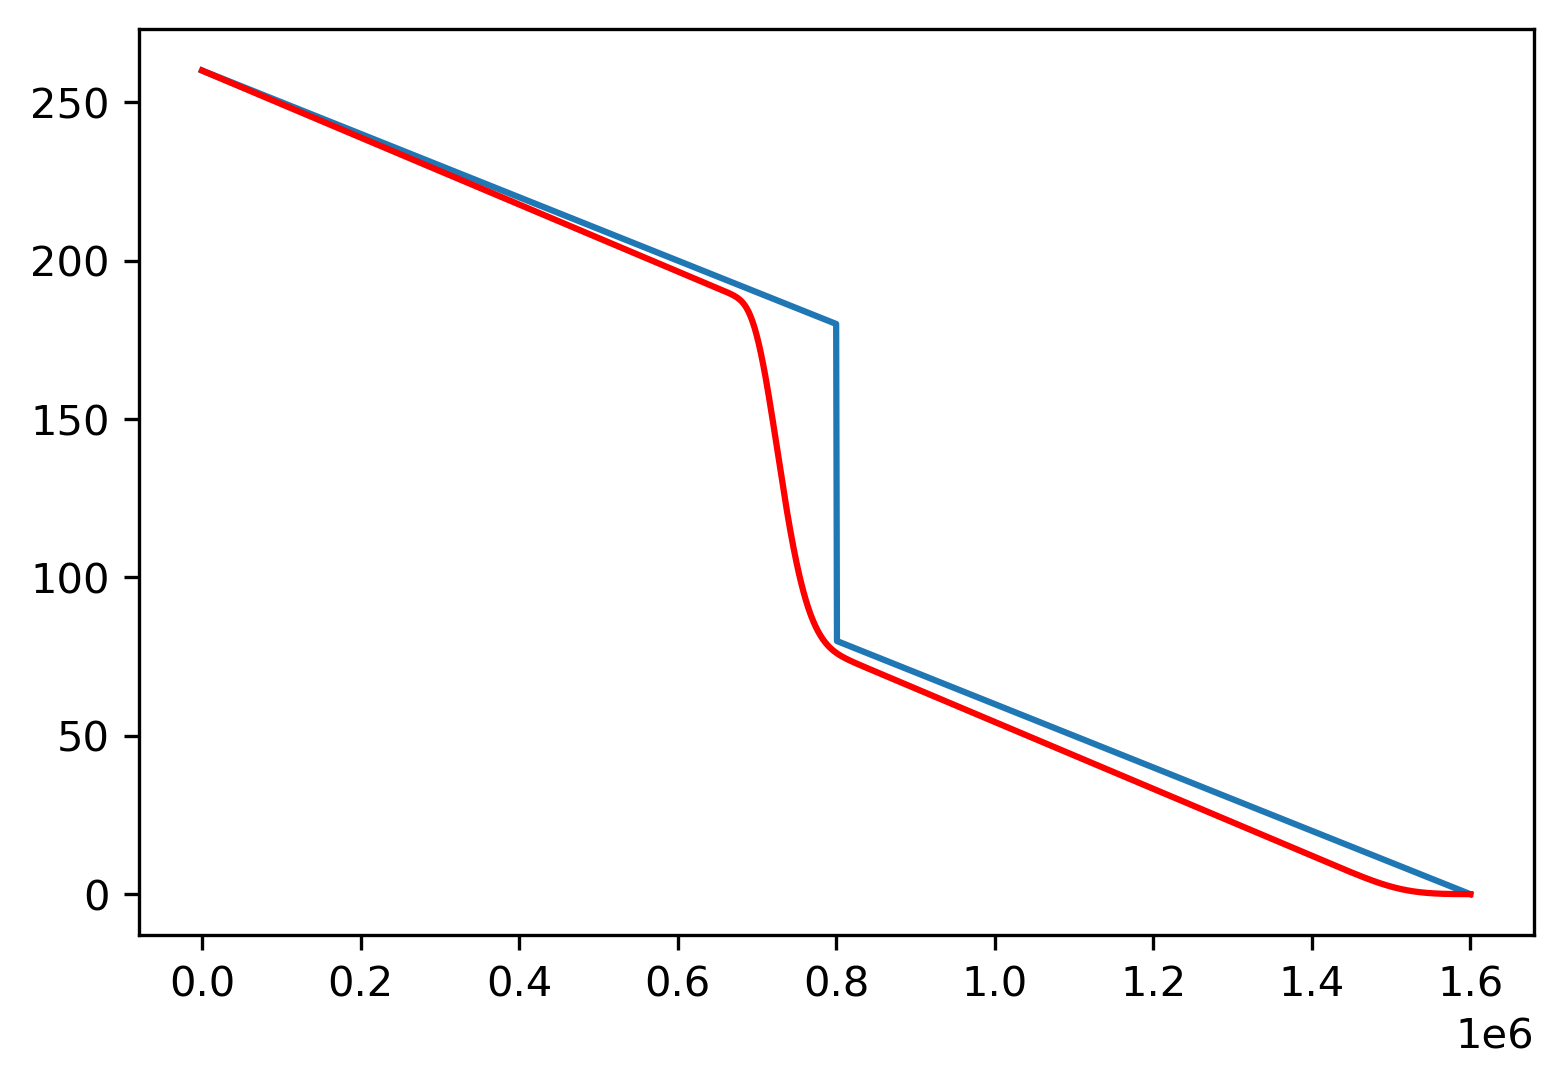

In [21]:
midrow = np.arange(ncols, ncols*2, dtype=int)
plt.plot(grid.x_of_node[midrow], init_elev[midrow])
plt.plot(grid.x_of_node[midrow], elev[midrow], 'r')
xpl = elev[midrow]

In [22]:
dt = 40000.0  # bigger than possible with explicit solver
nsteps = 5

# Grid for run with matrix solver
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
elev = grid.add_zeros("topographic__elevation", at="node")
elev[grid.x_of_node <= dx * ncols//2] += init_elev_plateau
xmax = np.amax(grid.x_of_node)
elev[:] += init_slope * (xmax - grid.x_of_node)
init_elev = elev.copy()

In [23]:
# Components
fa = FlowAccumulator(
    grid,
    runoff_rate=bf_runoff_rate,
    flow_director='FlowDirectorSteepest',
)
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abra_coef,
    solver="matrix"
)

In [24]:
# Loop
import time

start = time.time()
for _ in range(nsteps):
    fa.run_one_step()
    transporter.run_one_step(dt)
print('Time:', time.time() - start)

/Users/gtucker/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Time: 4.211879014968872


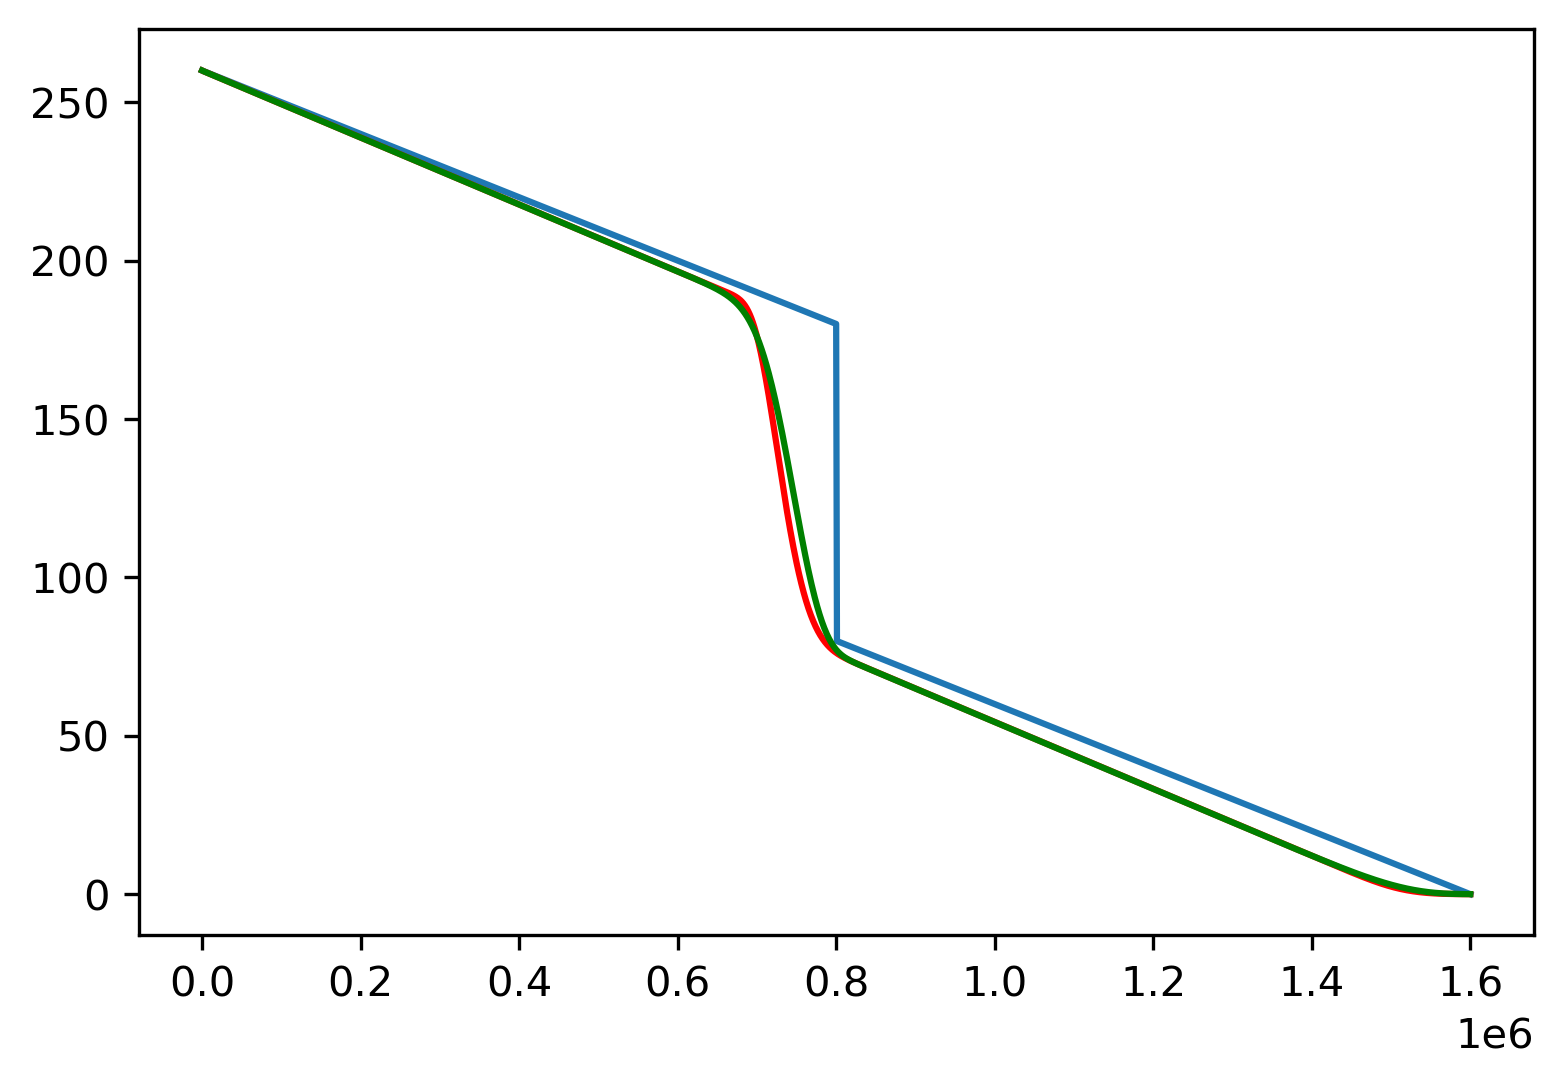

In [25]:
midrow = np.arange(ncols, ncols*2, dtype=int)
plt.plot(grid.x_of_node[midrow], init_elev[midrow])
plt.plot(grid.x_of_node[midrow], xpl, 'r')
plt.plot(grid.x_of_node[midrow], elev[midrow], 'g')

### More complex uplifted block

In [26]:
# Parameters
dx = 1000.0
nrows = 11
ncols = 50
init_elev_plateau = 100.0
noise_amp = 0.0
init_slope = 0.0001
abra_coef = 0.0 #1.0 / 5000.0  # abrasion coefficient, 1/m
bf_runoff_rate = 10.0  # bankfull runoff rate, m/y
nsteps = 1000
dt = 100.0  # time step, y
plot_interval = 200

np.random.seed(0)
next_plot = plot_interval

In [27]:
# Grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
elev = grid.add_zeros("topographic__elevation", at="node")
elev[grid.core_nodes] += noise_amp * np.random.rand(grid.number_of_core_nodes)
elev[grid.x_of_node <= dx * ncols//2] += init_elev_plateau
#elev[grid.y_of_node > dx * nrows//2] += 0.5 * init_elev_plateau
xmax = np.amax(grid.x_of_node)
elev[:] += init_slope * (xmax - grid.x_of_node)
elev[:] += 10.0 * np.sin(2 * np.pi * grid.y_of_node / (dx * 10) + np.pi / 2.0)
init_elev = elev.copy()


In [28]:
# Components
fa = FlowAccumulator(
    grid,
    runoff_rate=bf_runoff_rate,
    flow_director='FlowDirectorSteepest',
)
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abra_coef,
    solver="explicit"
)

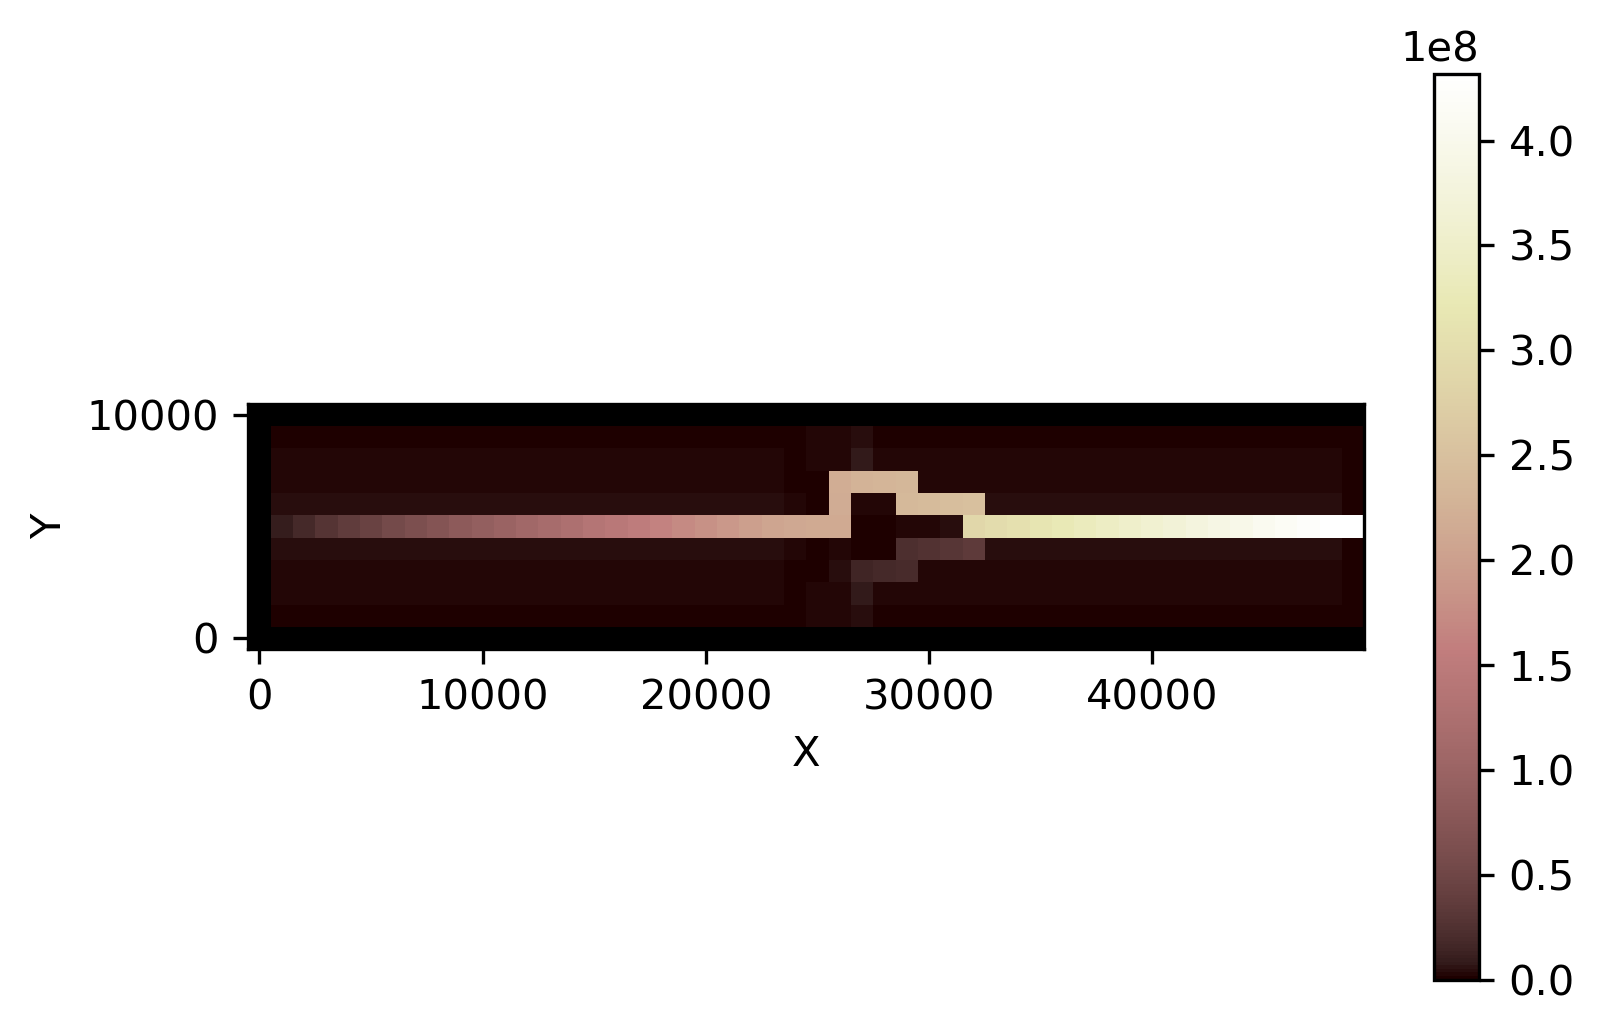

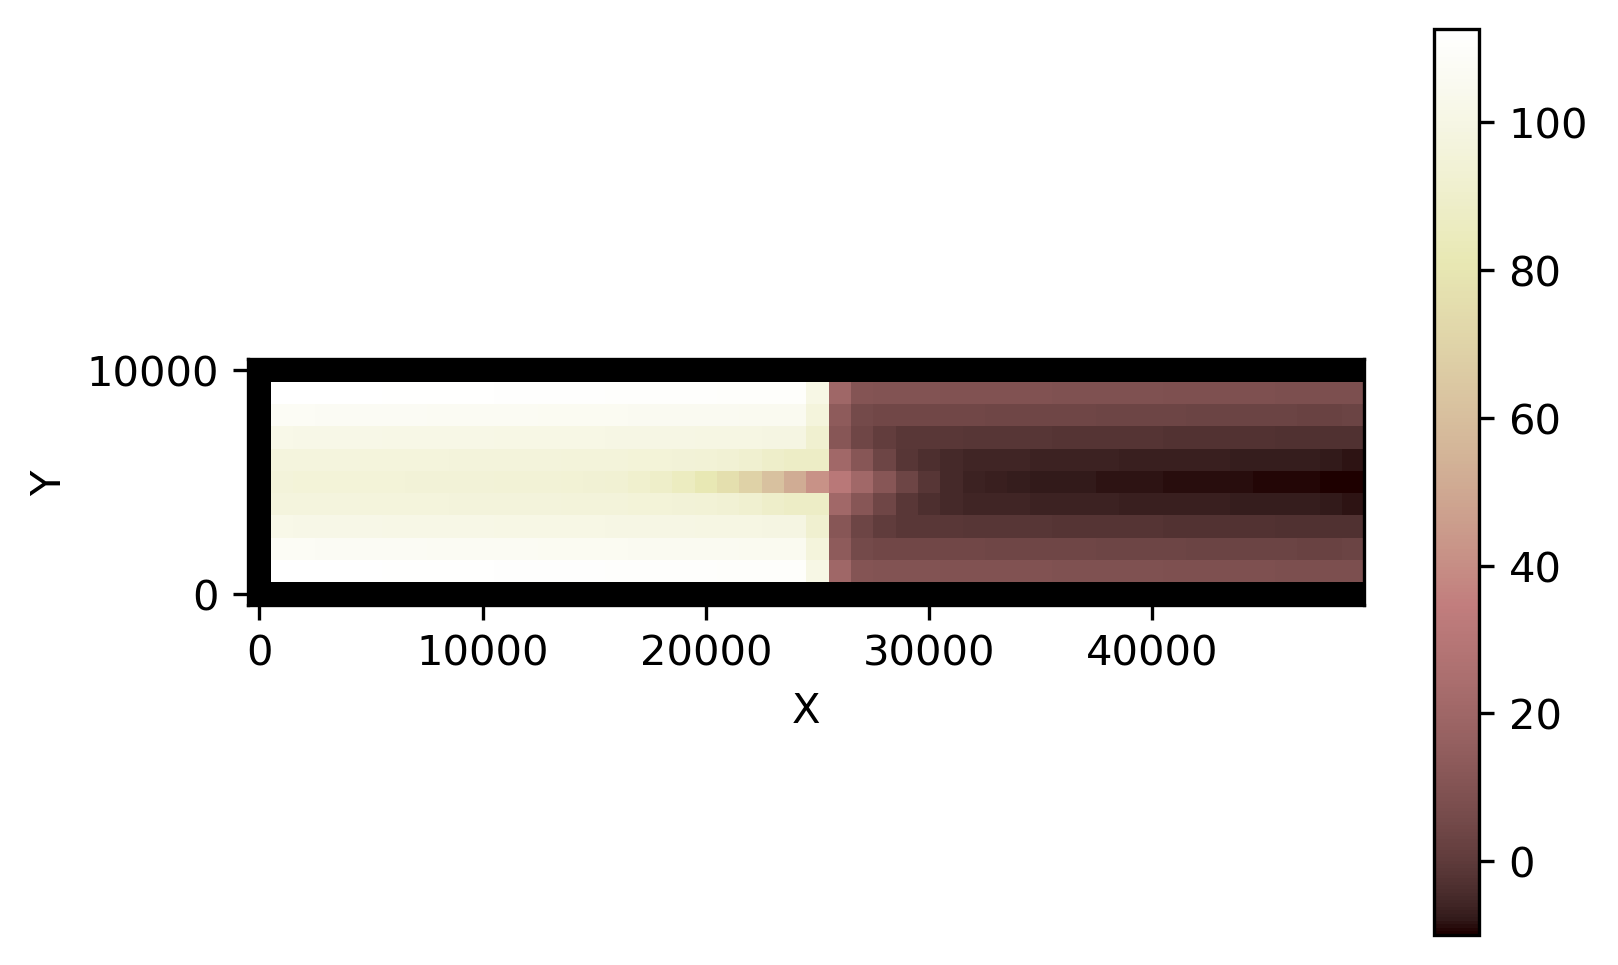

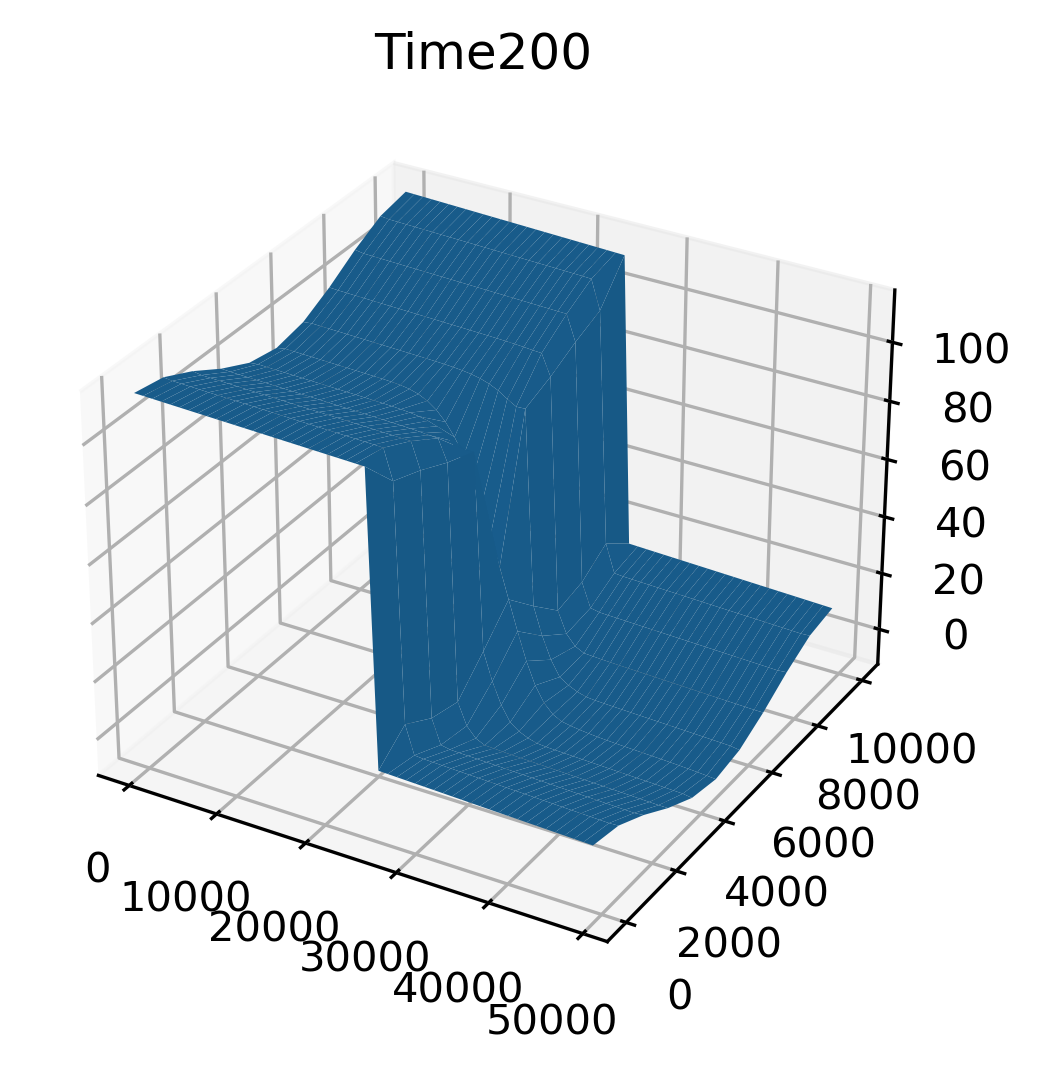

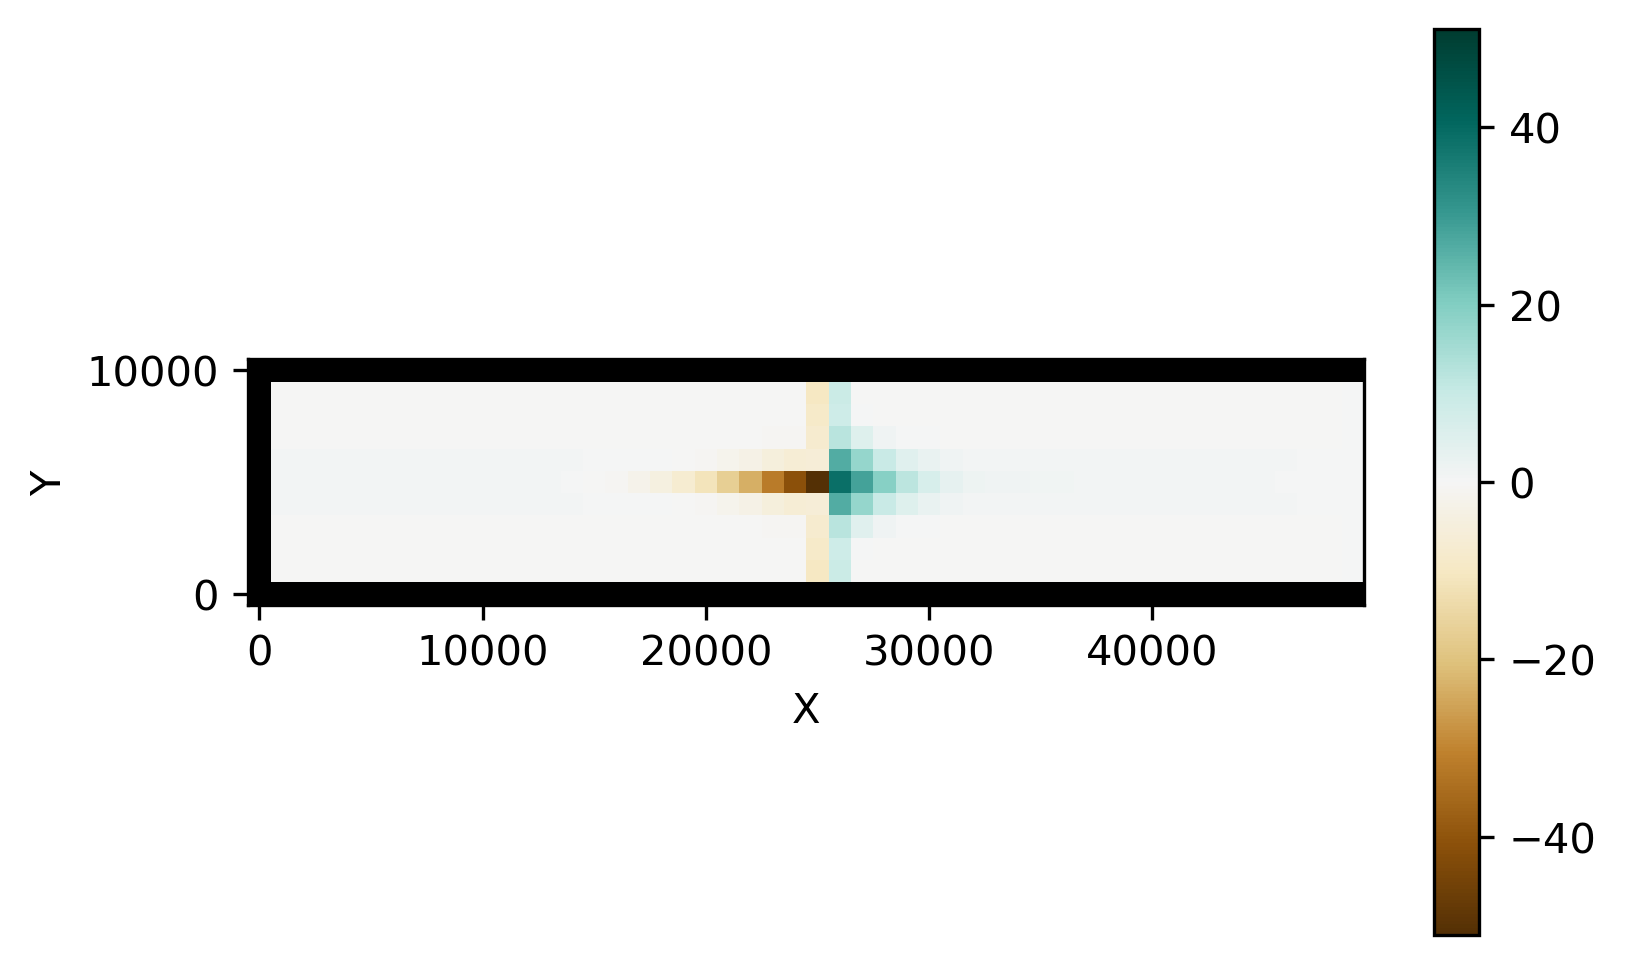

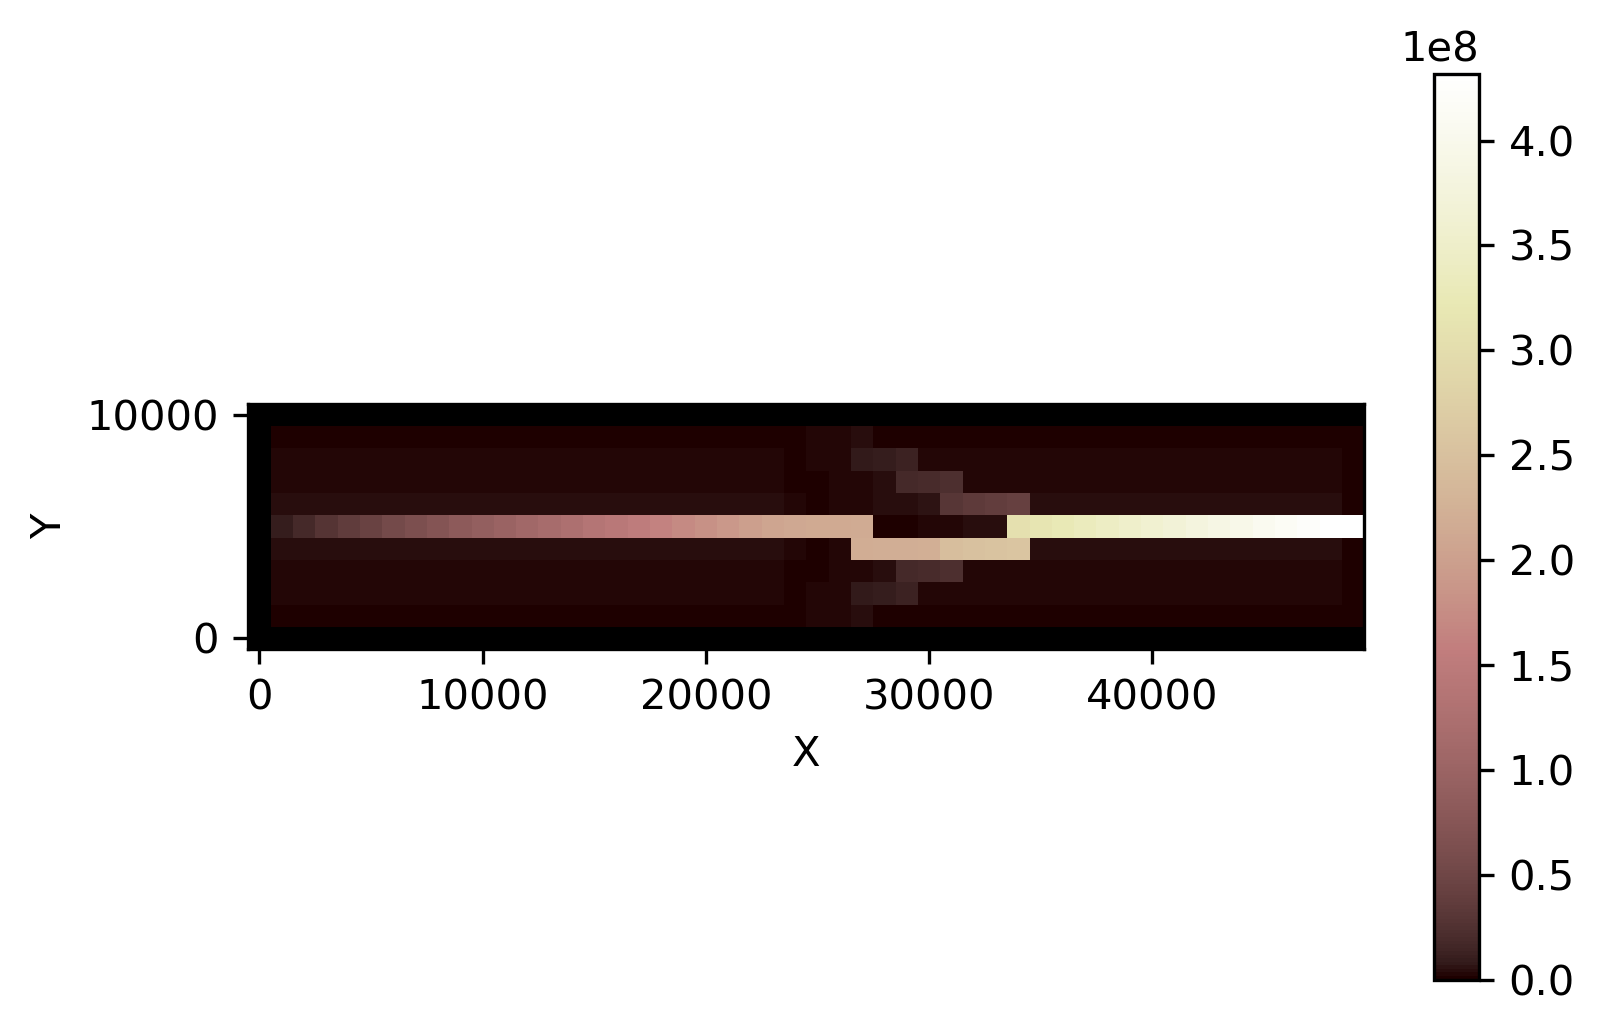

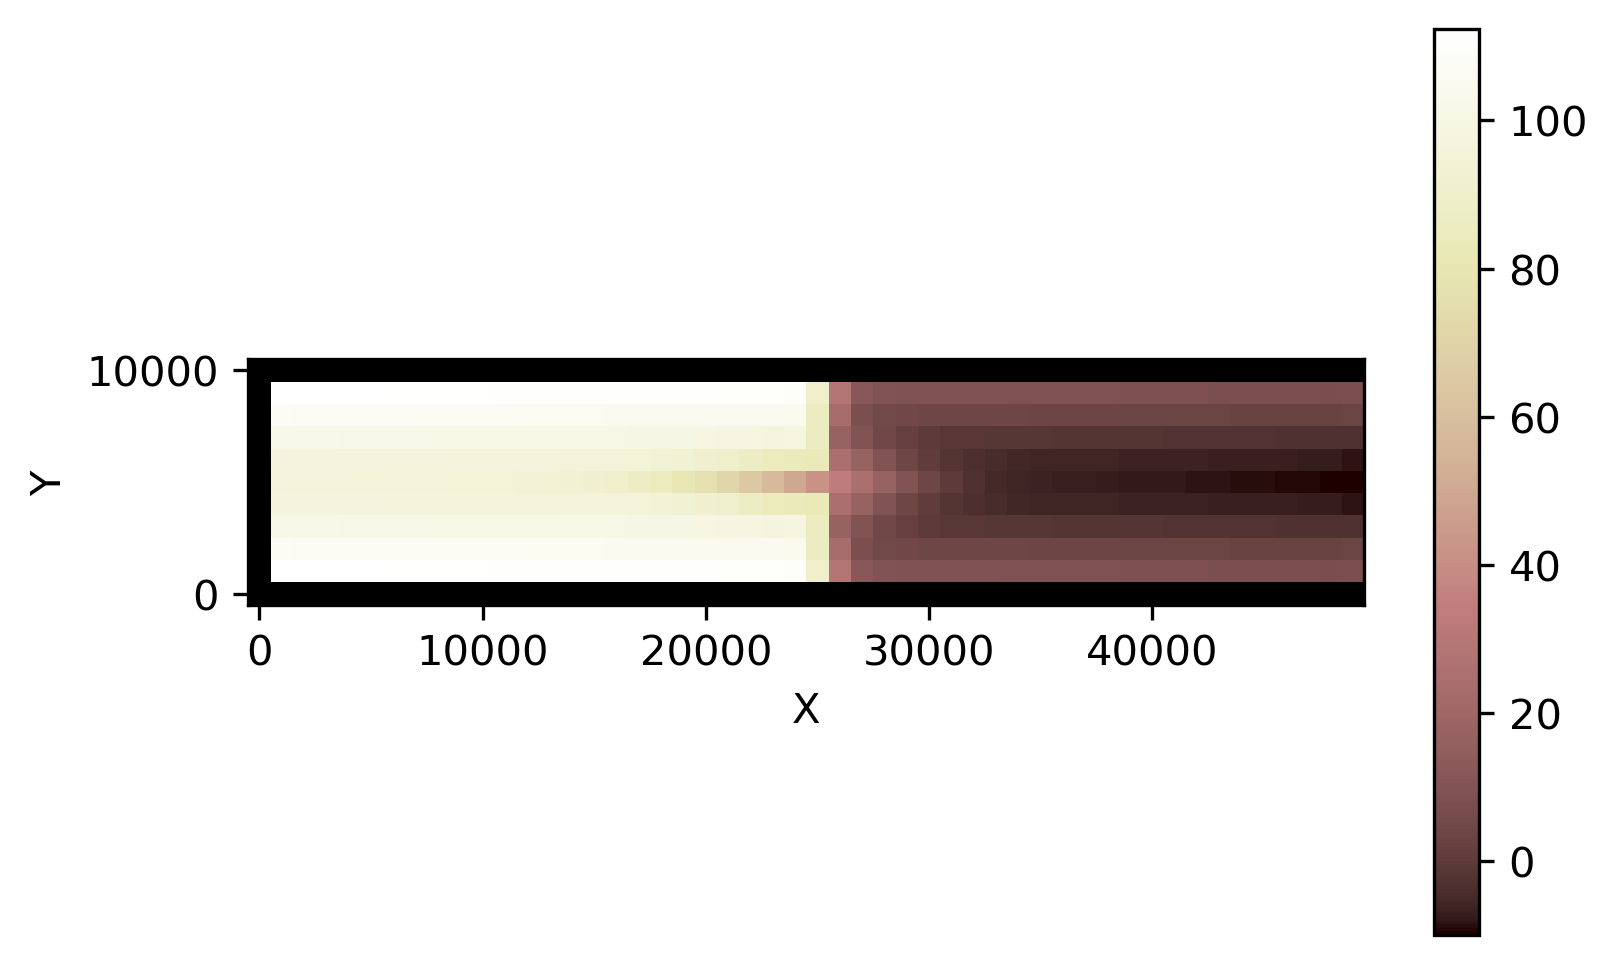

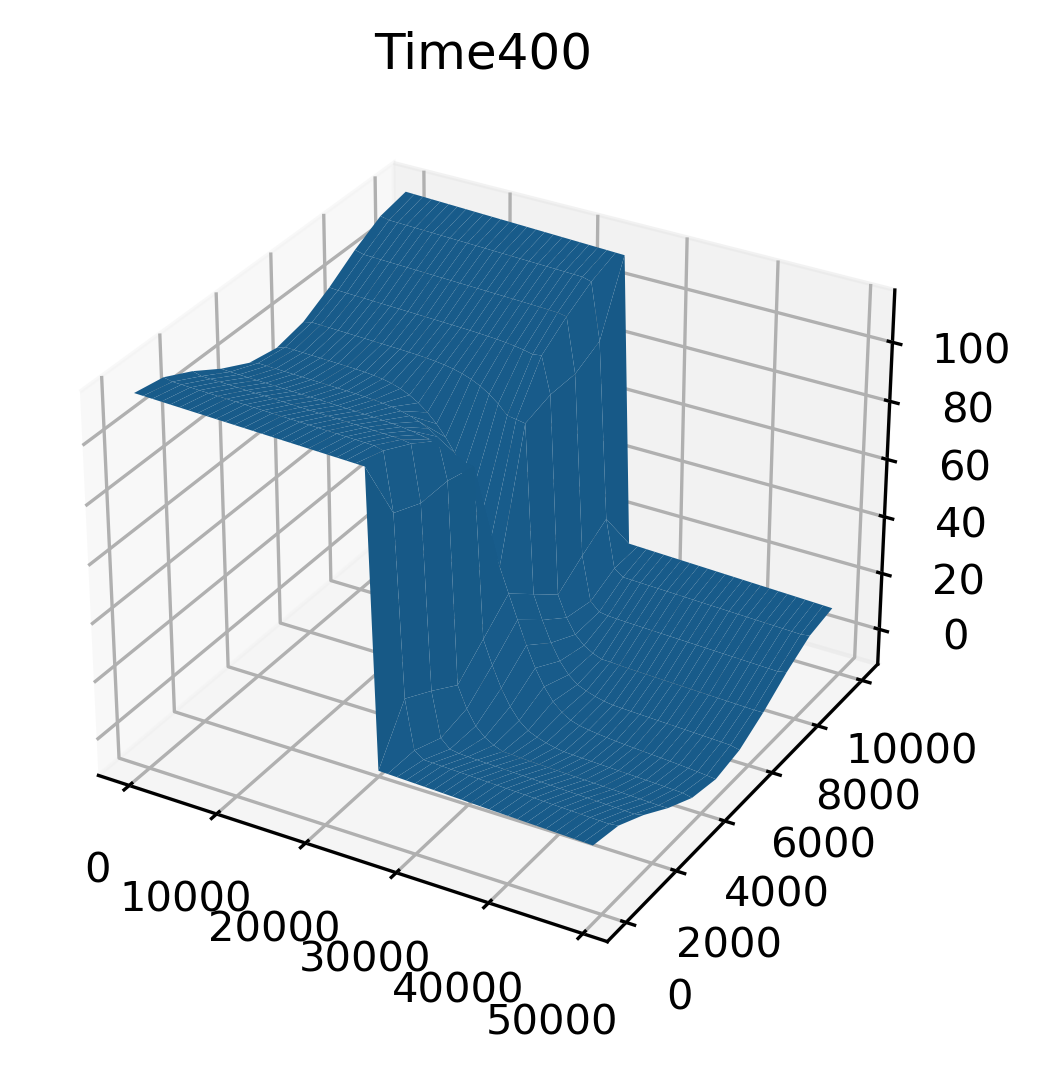

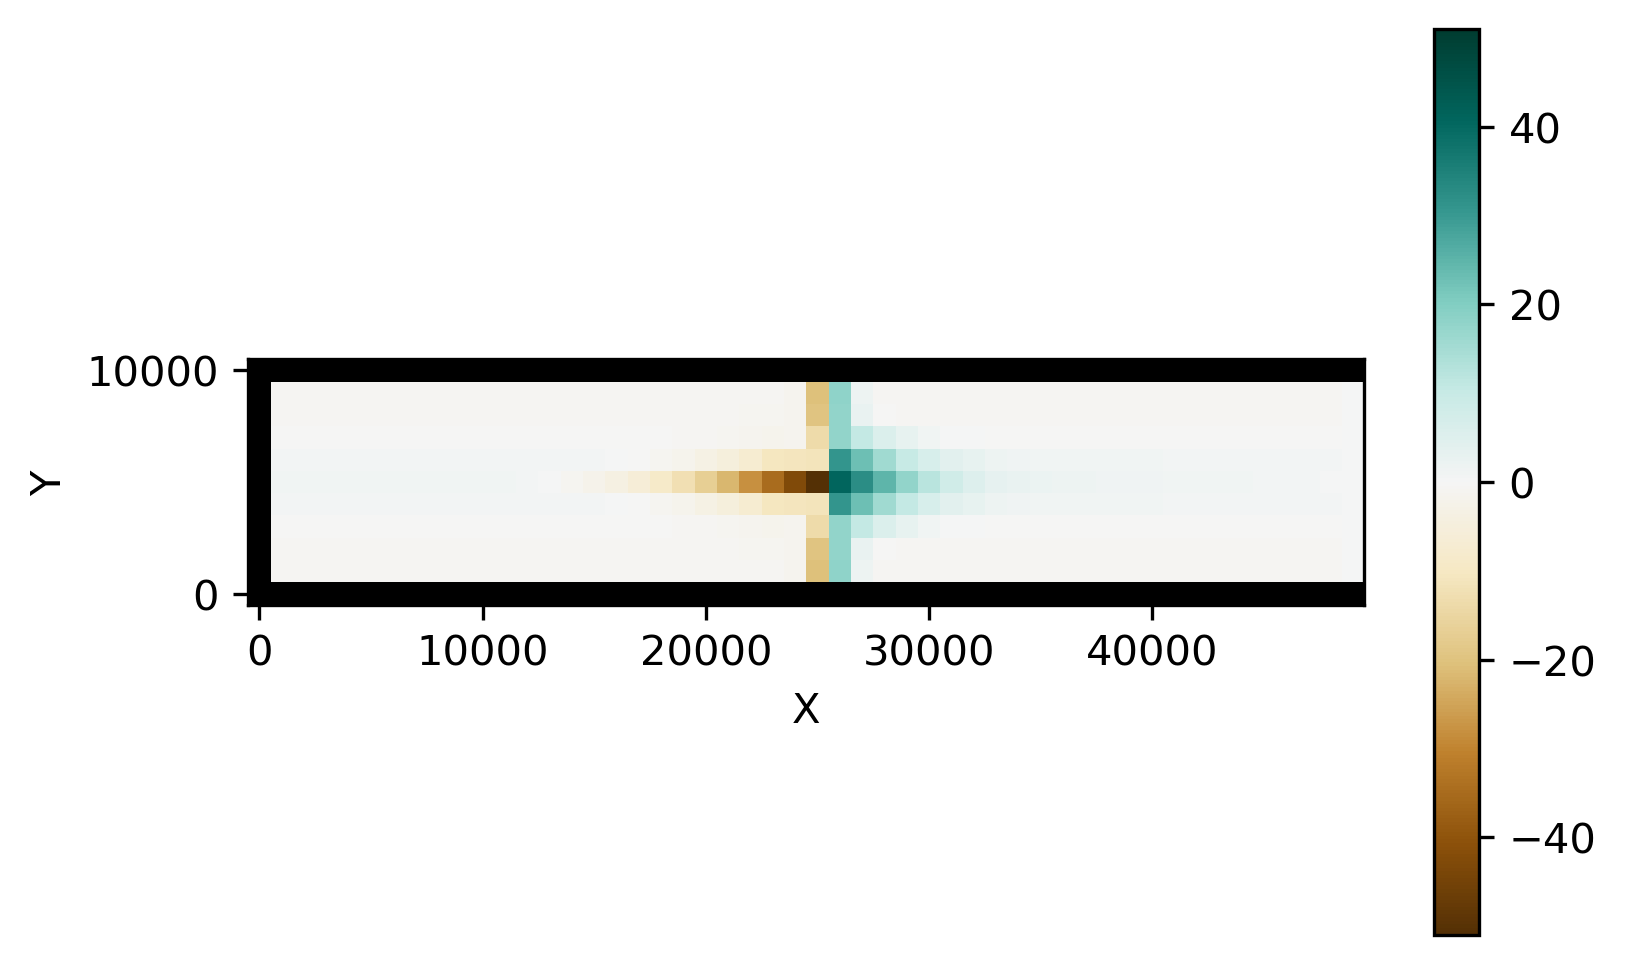

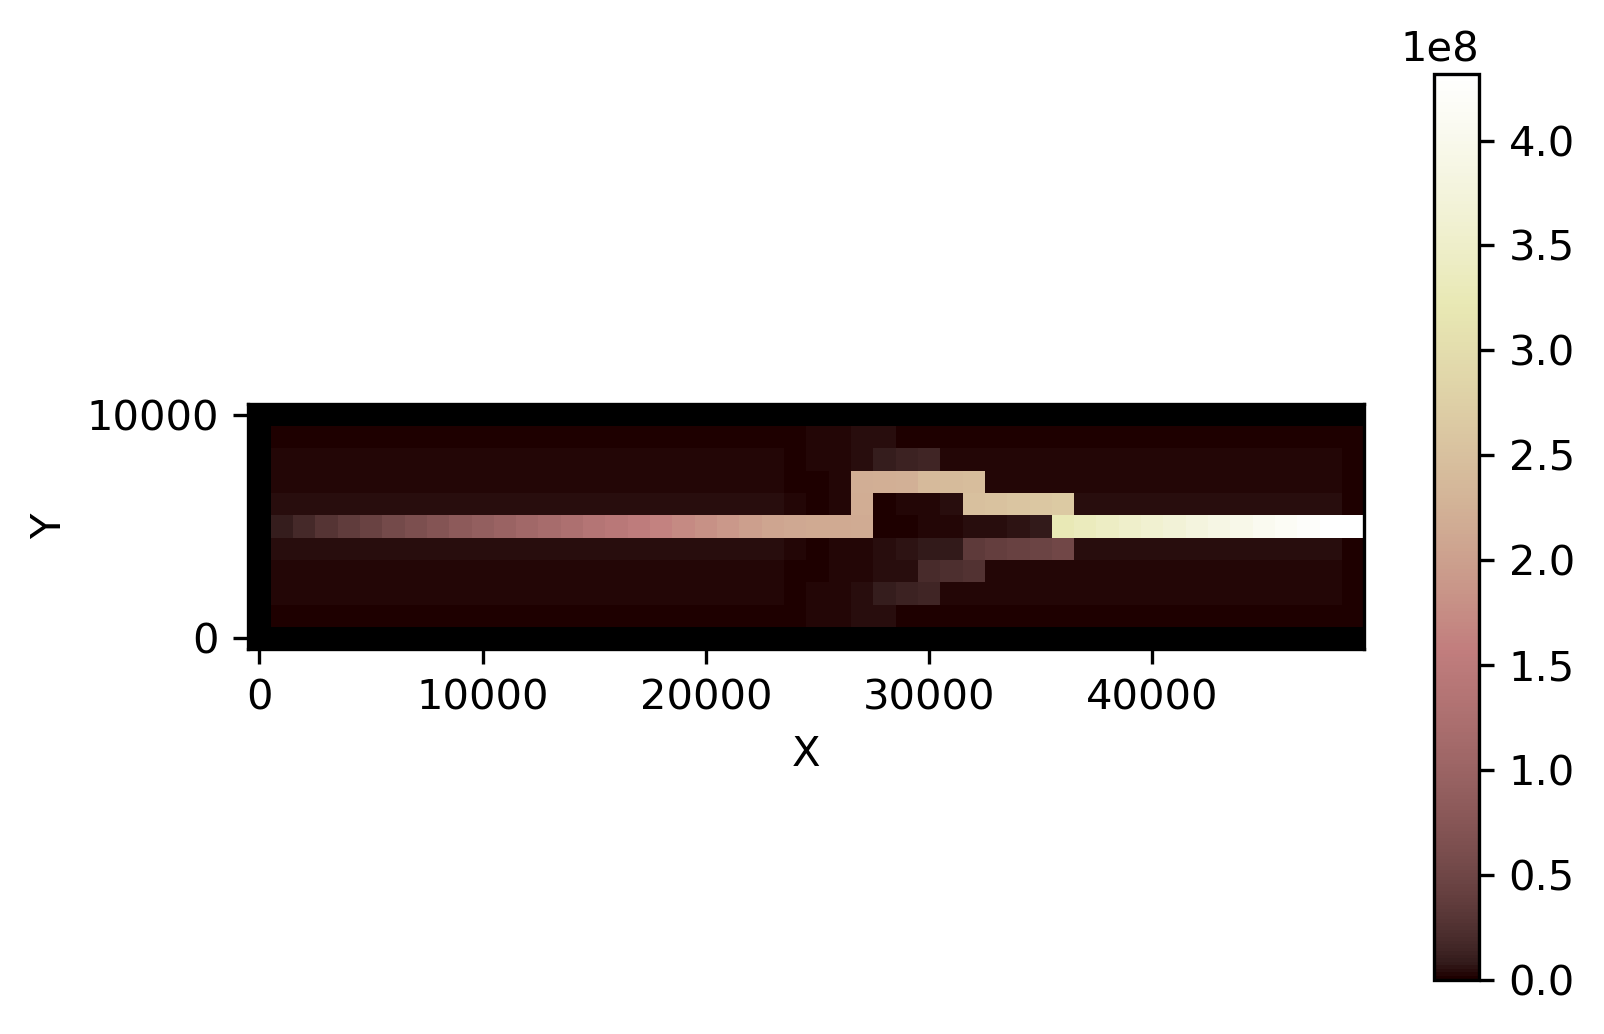

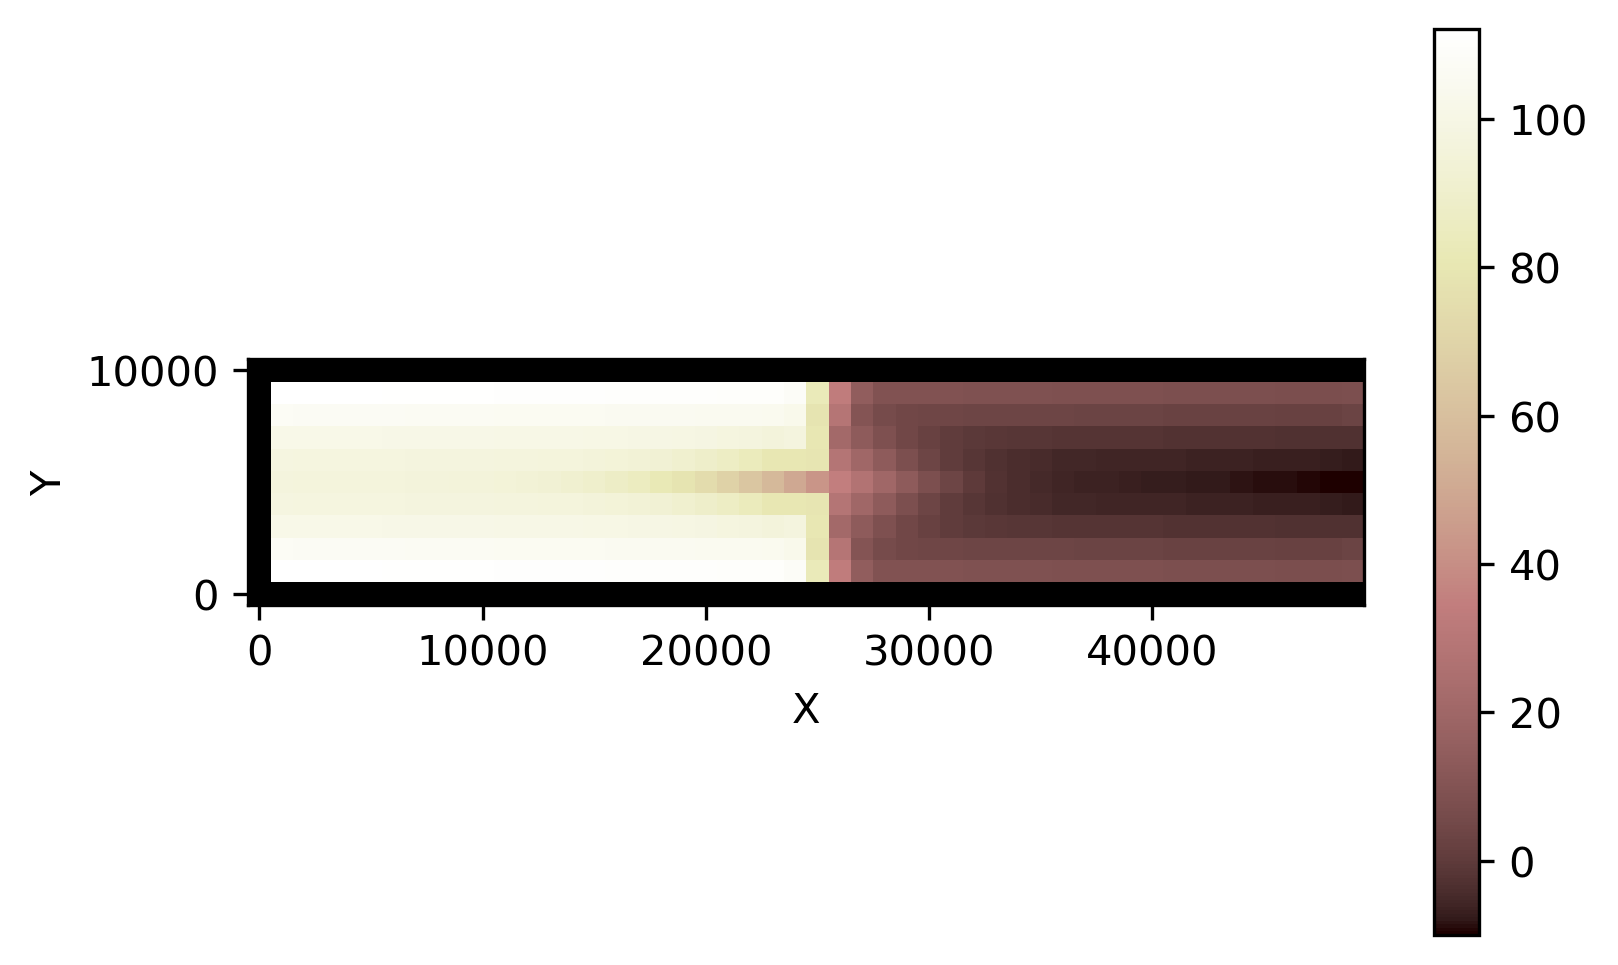

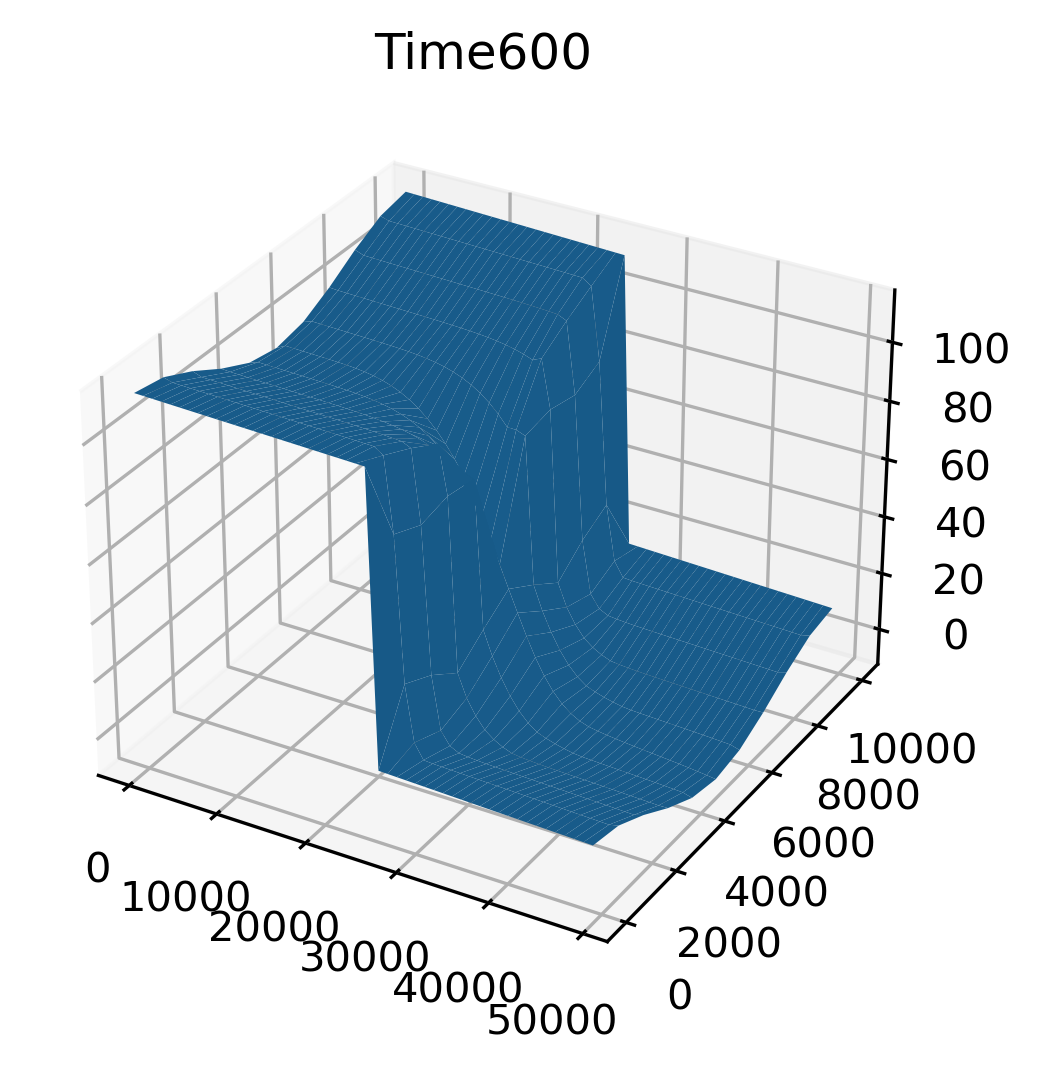

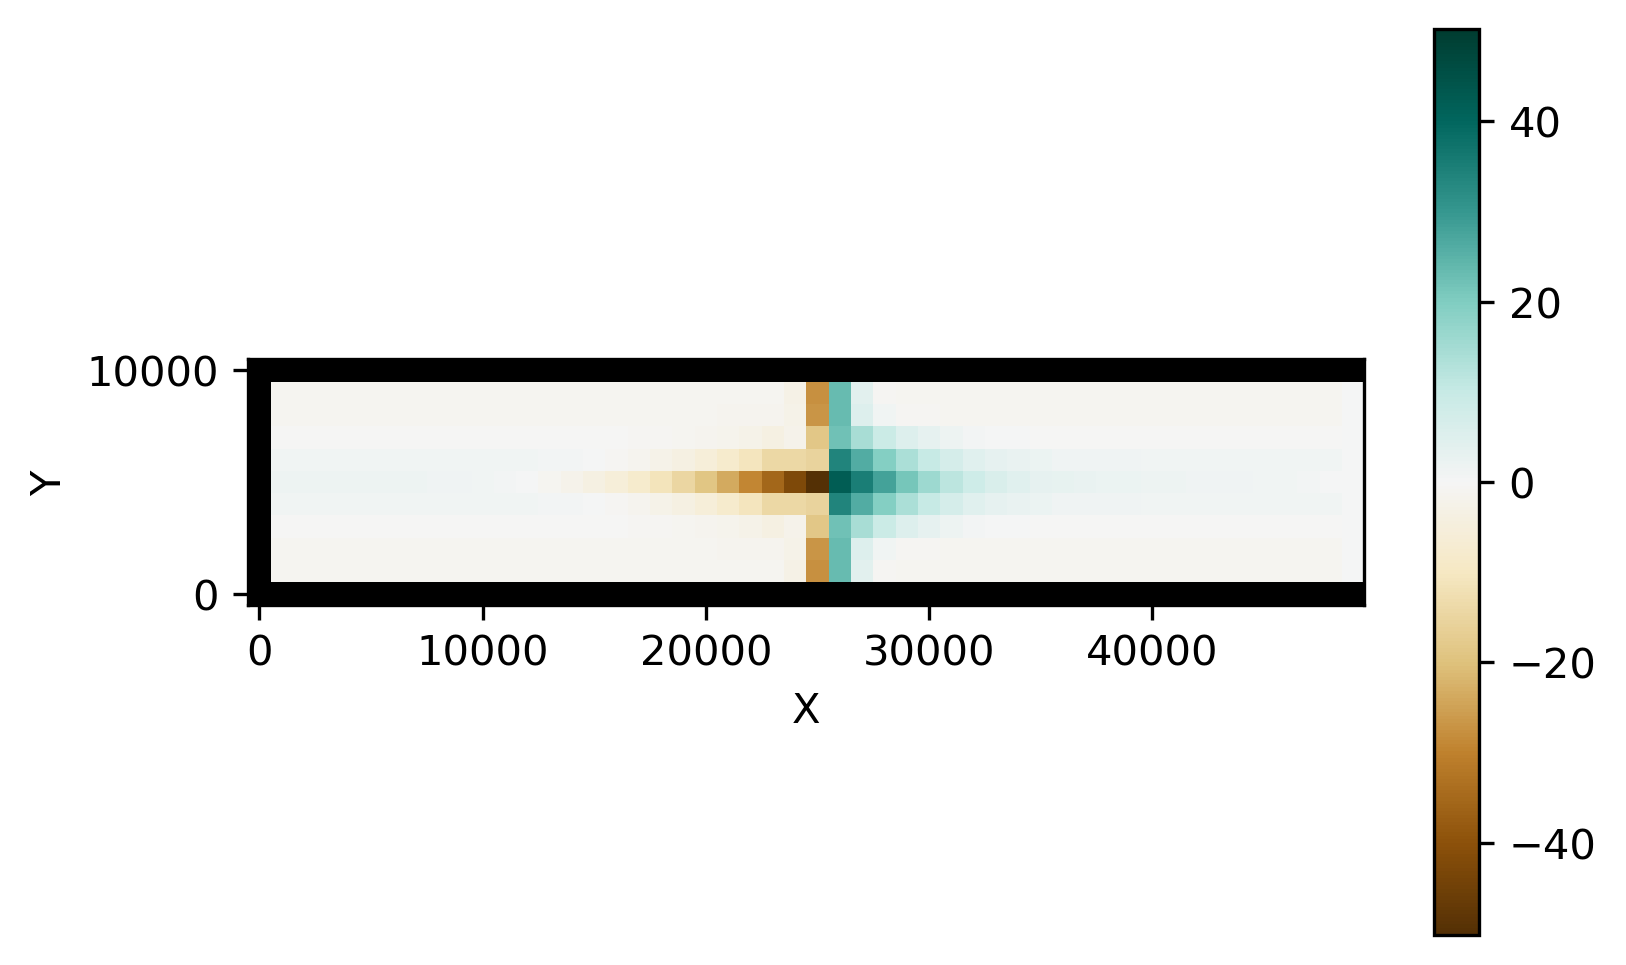

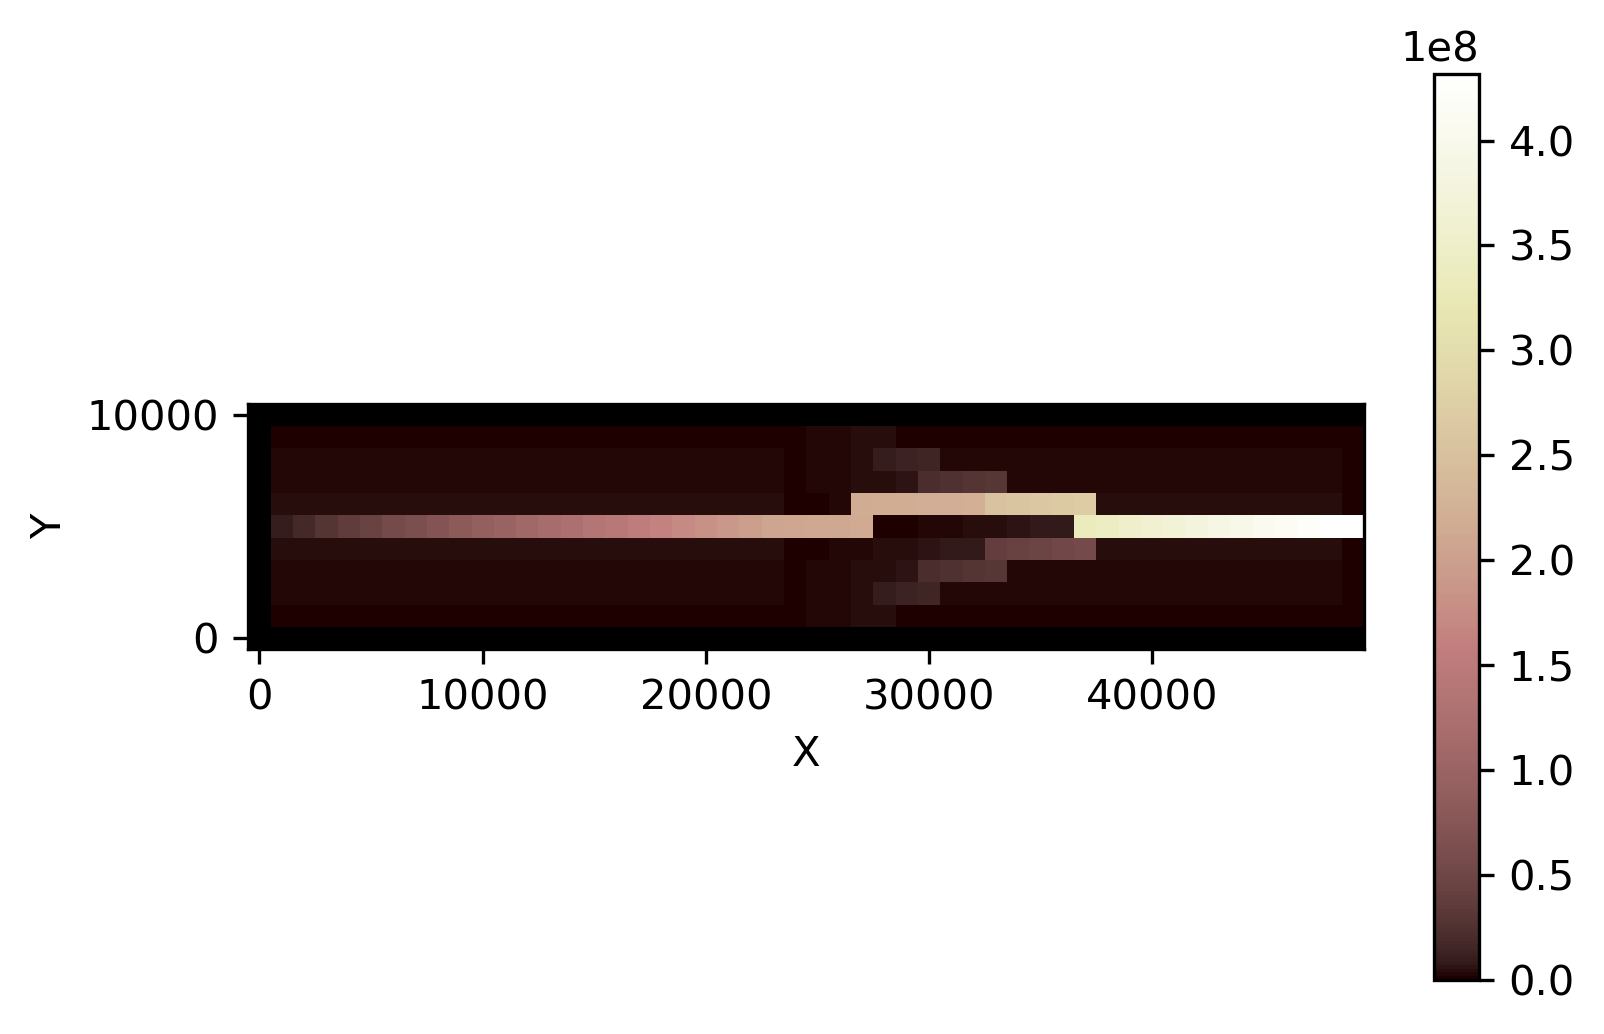

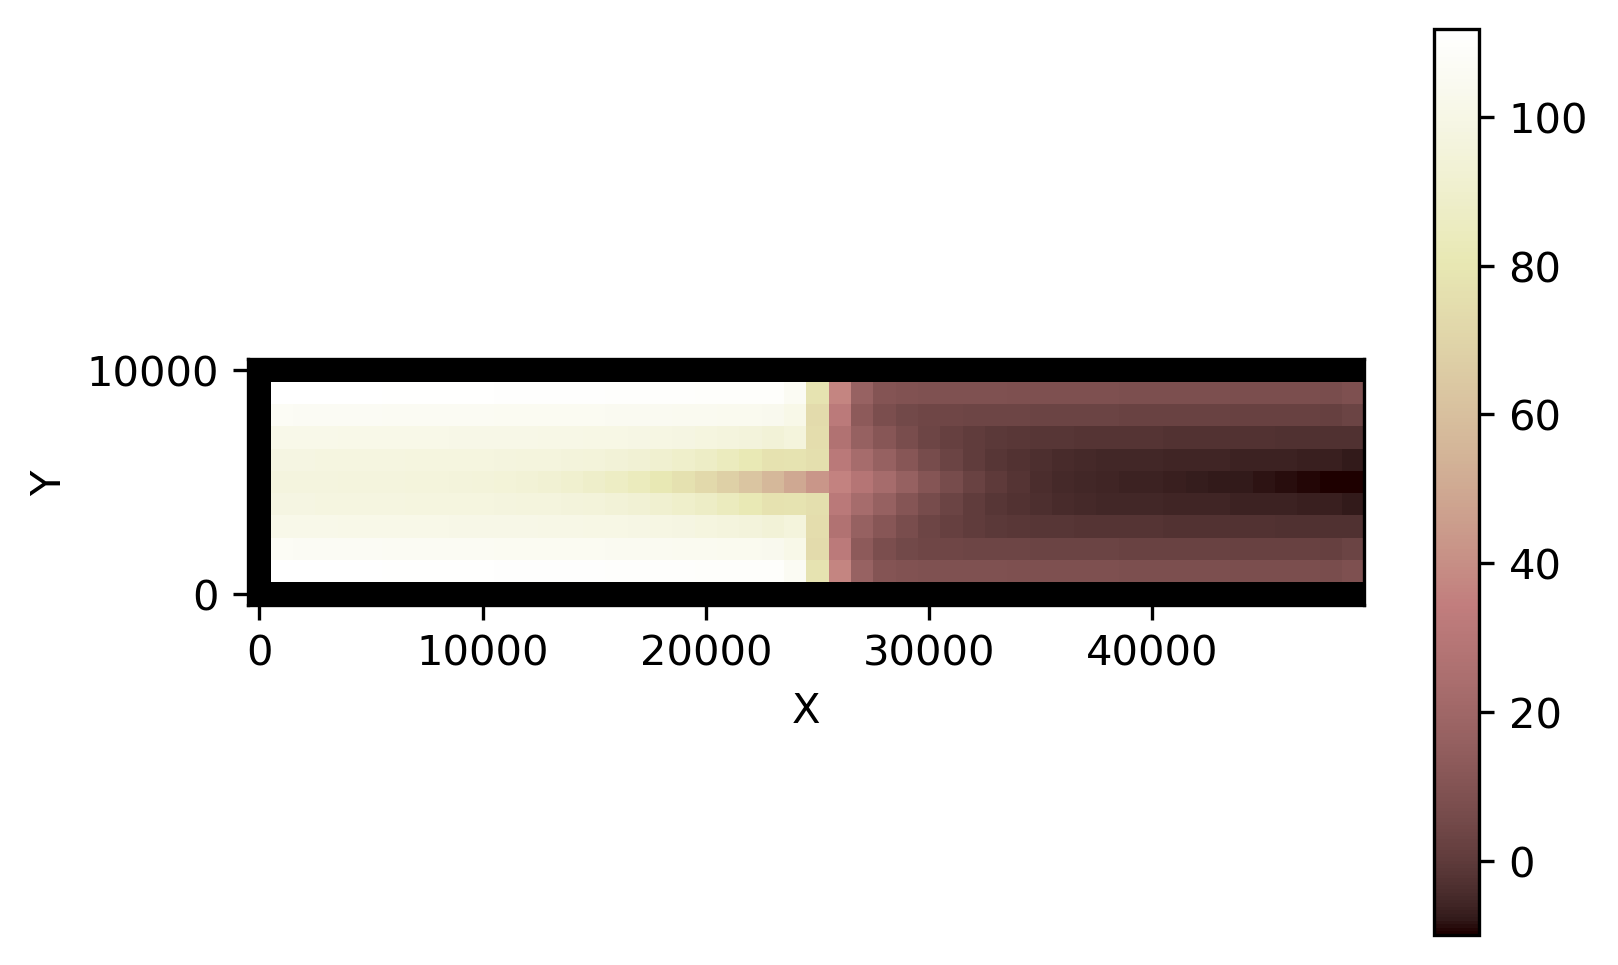

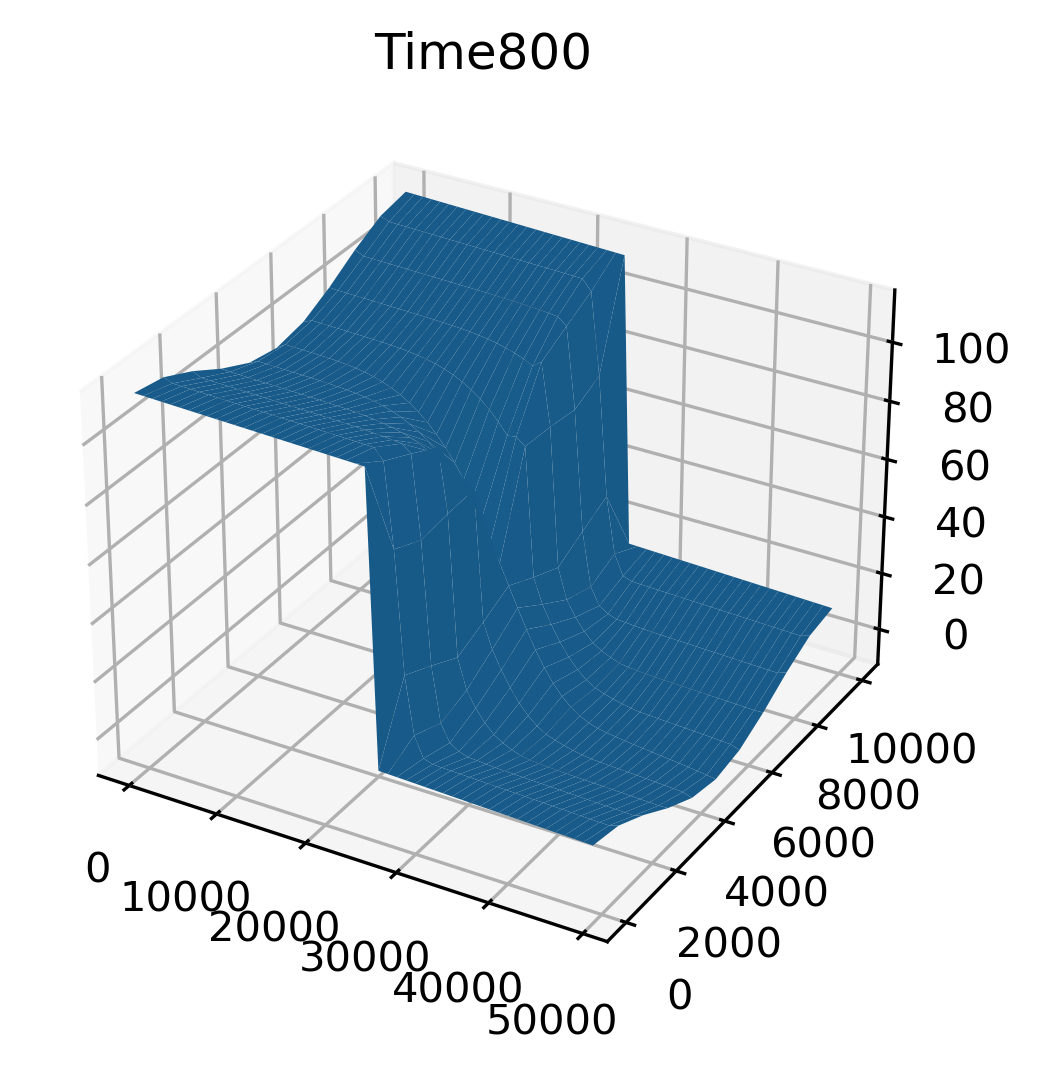

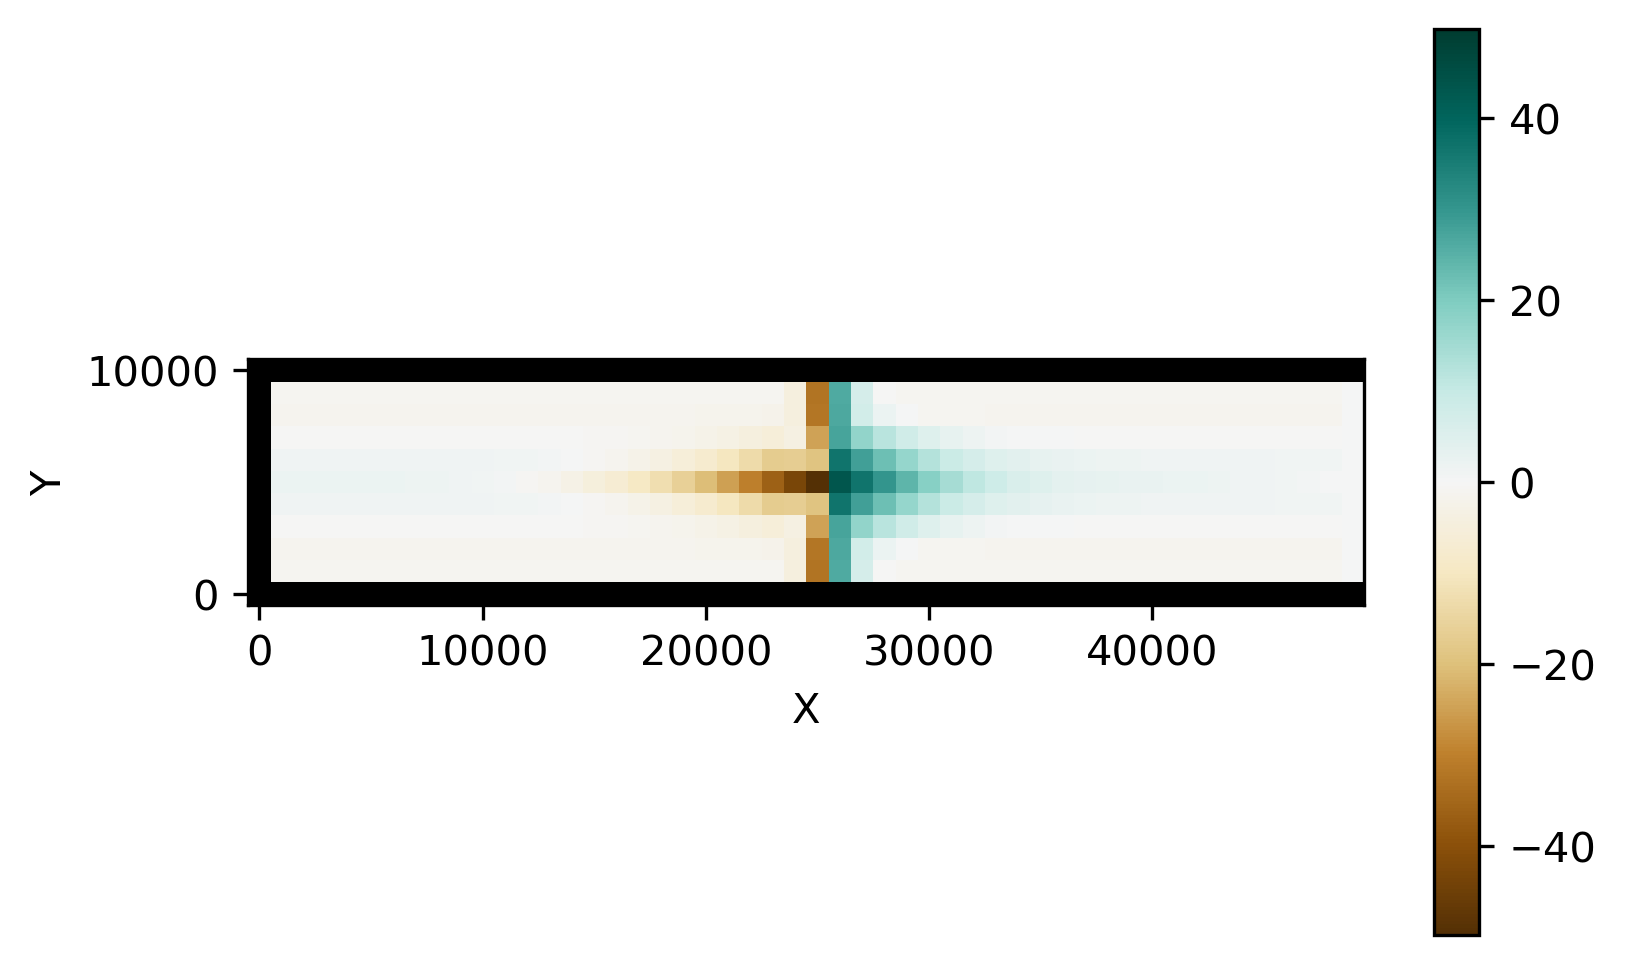

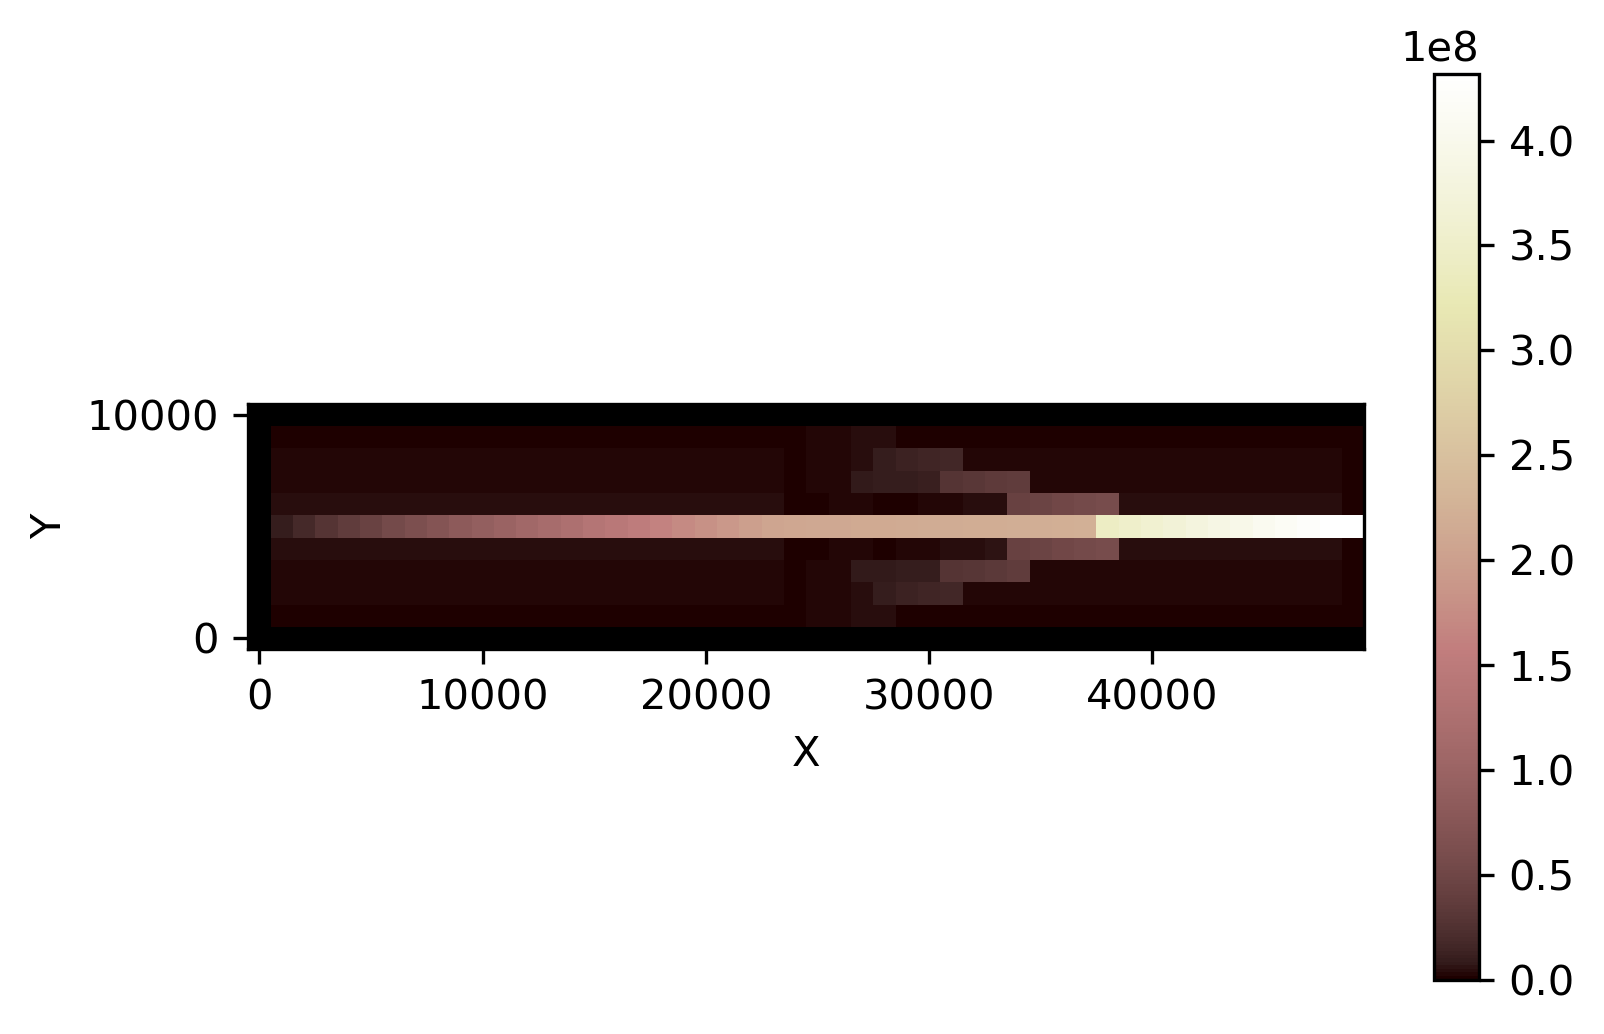

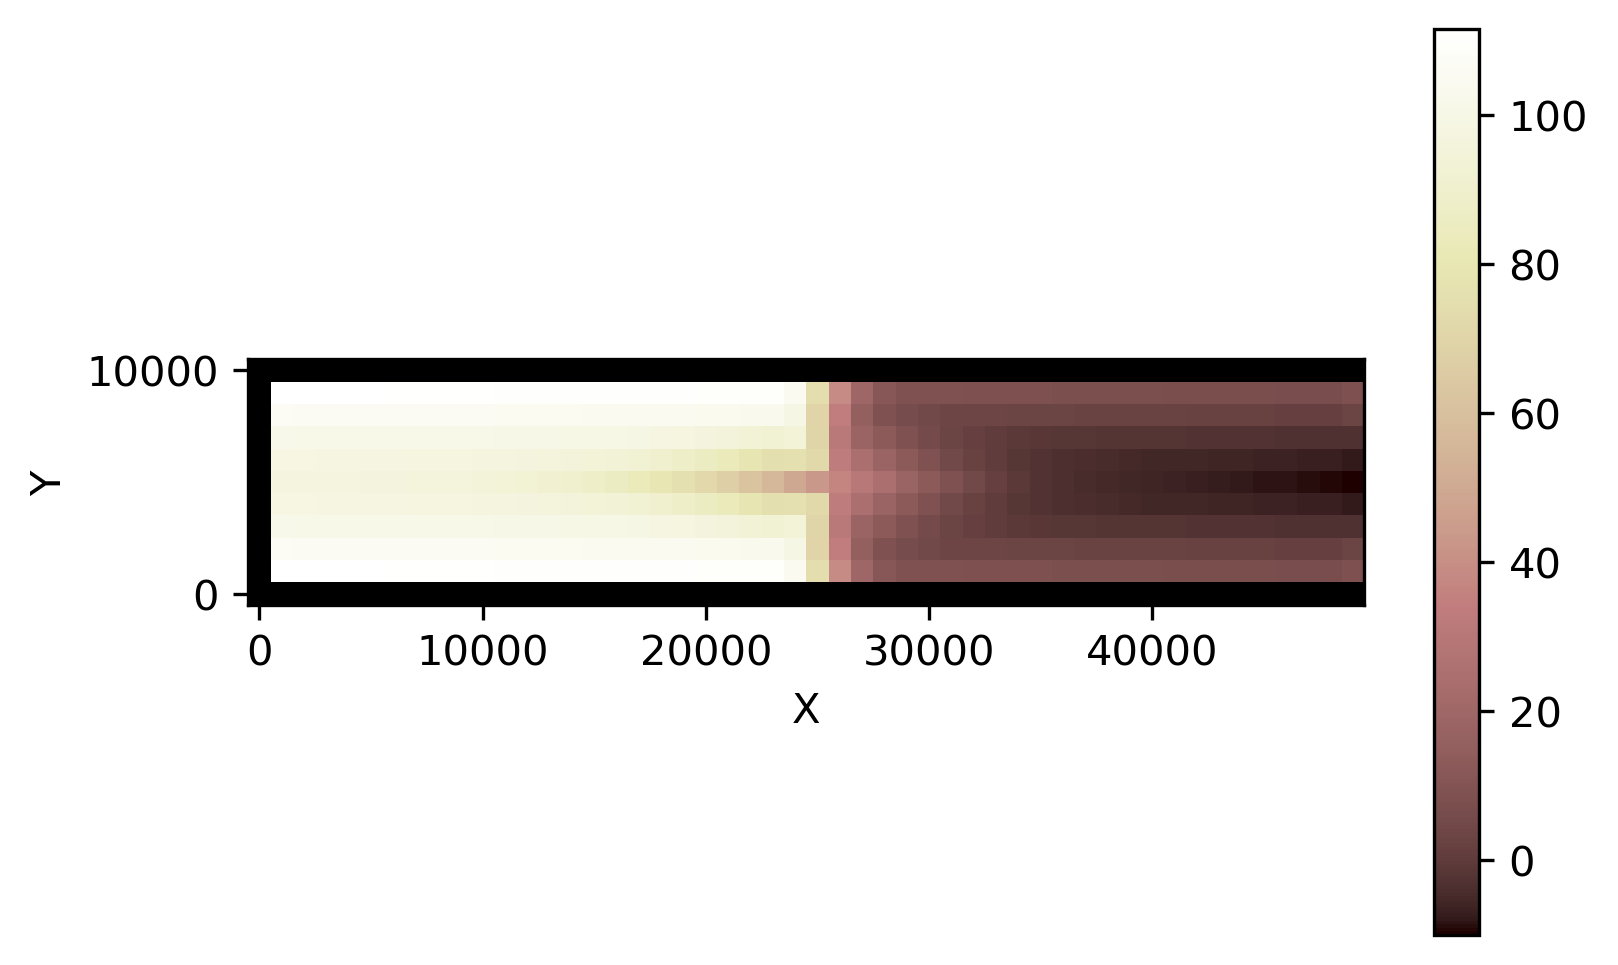

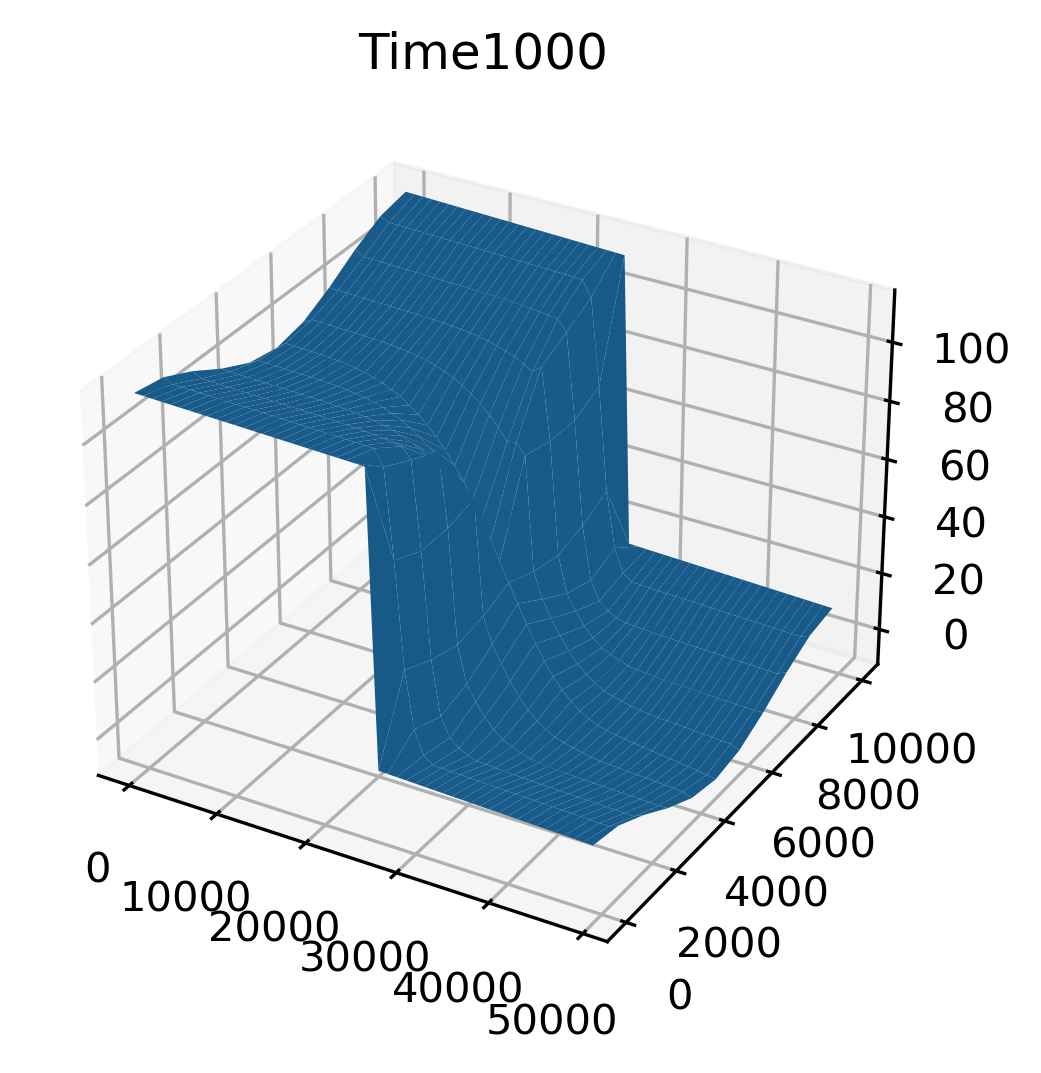

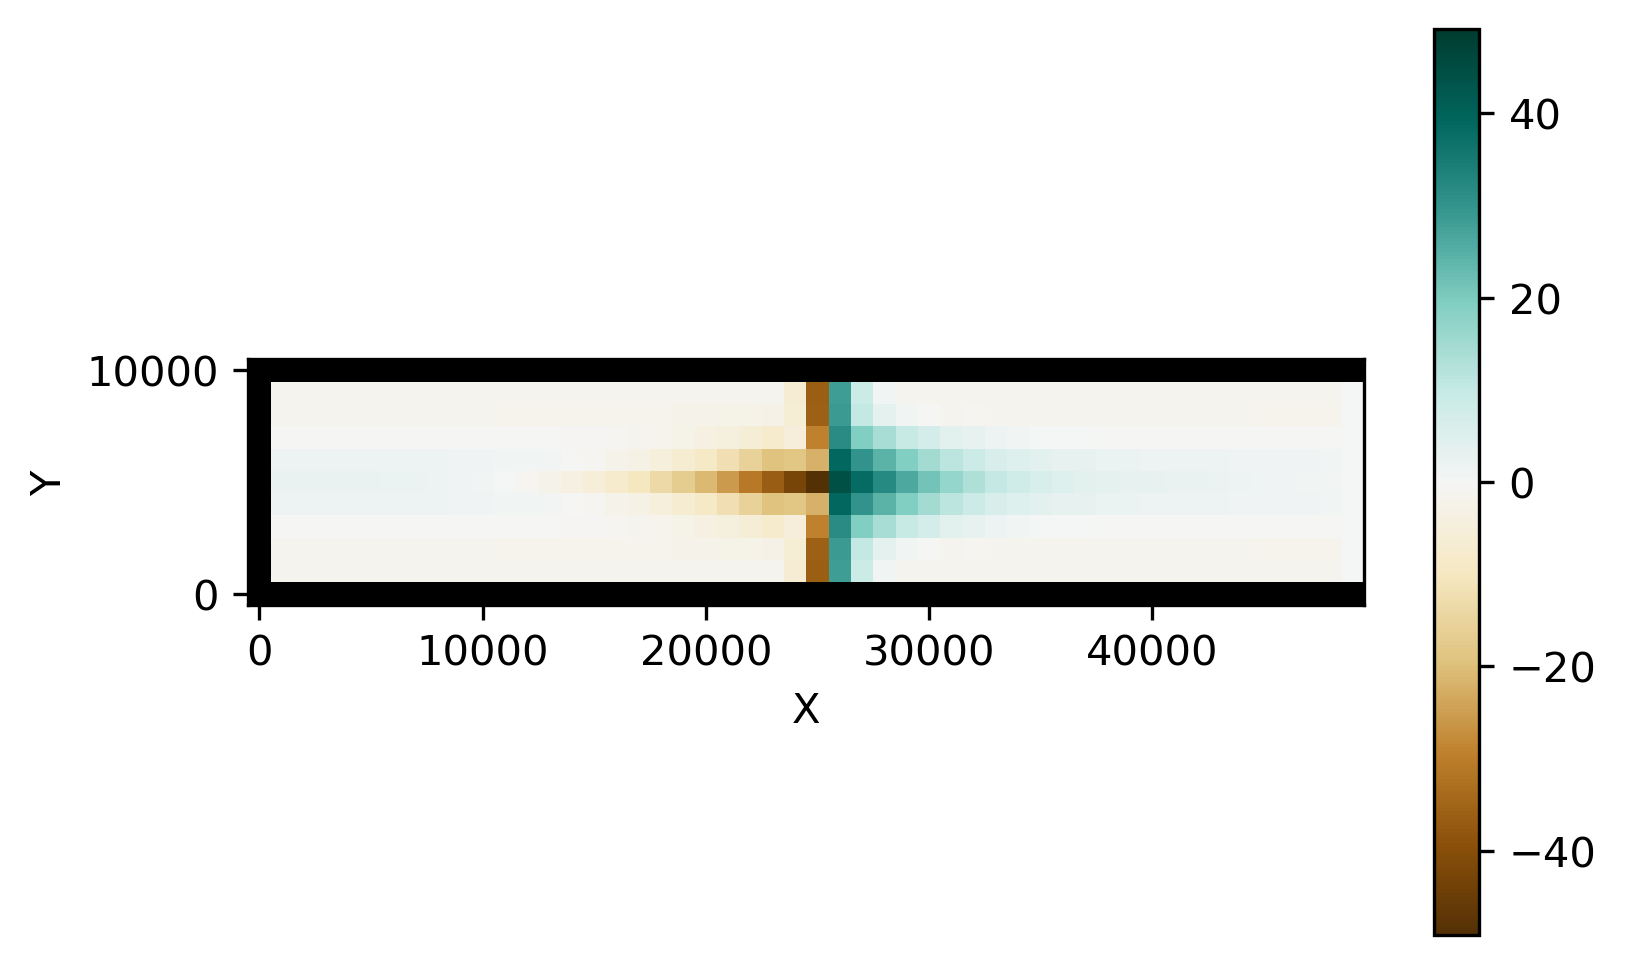

In [29]:
# Loop
for i in range(1, nsteps + 1):
    fa.run_one_step()
    transporter.run_one_step(dt)
    
    if i>= next_plot:
        plt.figure()
        imshow_grid(grid, grid.at_node["drainage_area"])
        plt.figure()
        imshow_grid(grid, elev)
        plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_surface(grid.x_of_node.reshape((nrows, ncols)),
                        grid.y_of_node.reshape((nrows, ncols)),
                        elev.reshape((nrows, ncols)))
        plt.title('Time' + str(i))
        plt.figure()
        dz = elev - init_elev
        cr = np.amax(np.abs(dz))
        imshow_grid(grid, dz, cmap='BrBG', vmin=-cr, vmax=cr)
        next_plot += plot_interval

In [30]:
print(elev[325:327])
print(grid.at_node['bedload_sediment__volume_influx'][325:327])
print(transporter._sediment_influx[325:327])
print(grid.at_node['bedload_sediment__volume_outflux'][325:327])
print(transporter._sediment_outflux[325:327])
print(transporter._receiver_node[325:327])

[ 72.16259101  33.07047431]
[  0.         93.4389915]
[  0.         93.4389915]
[ 93.4389915   32.92018002]
[ 93.4389915   32.92018002]
[326 327]


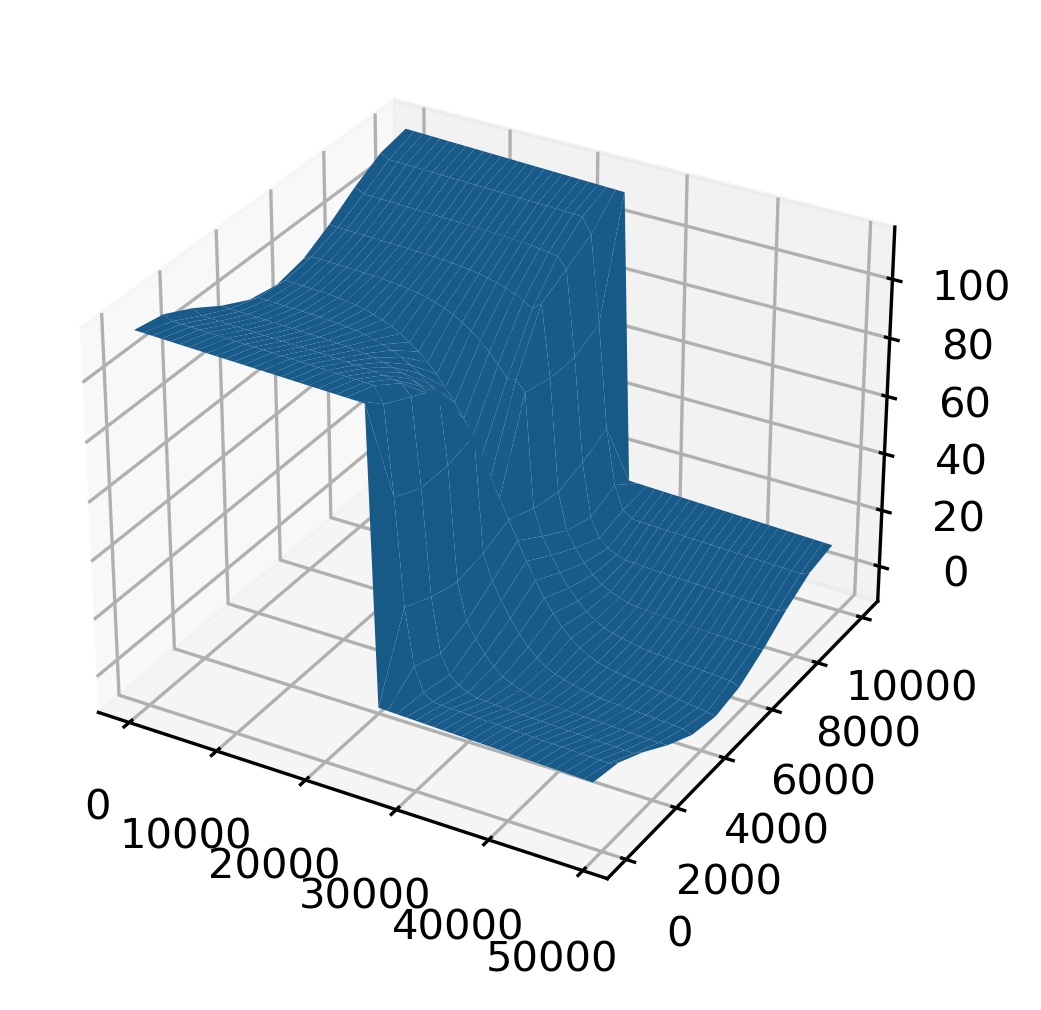

In [31]:
ax = plt.axes(projection='3d')
ax.plot_surface(grid.x_of_node.reshape((nrows, ncols)),
                grid.y_of_node.reshape((nrows, ncols)),
                elev.reshape((nrows, ncols)))

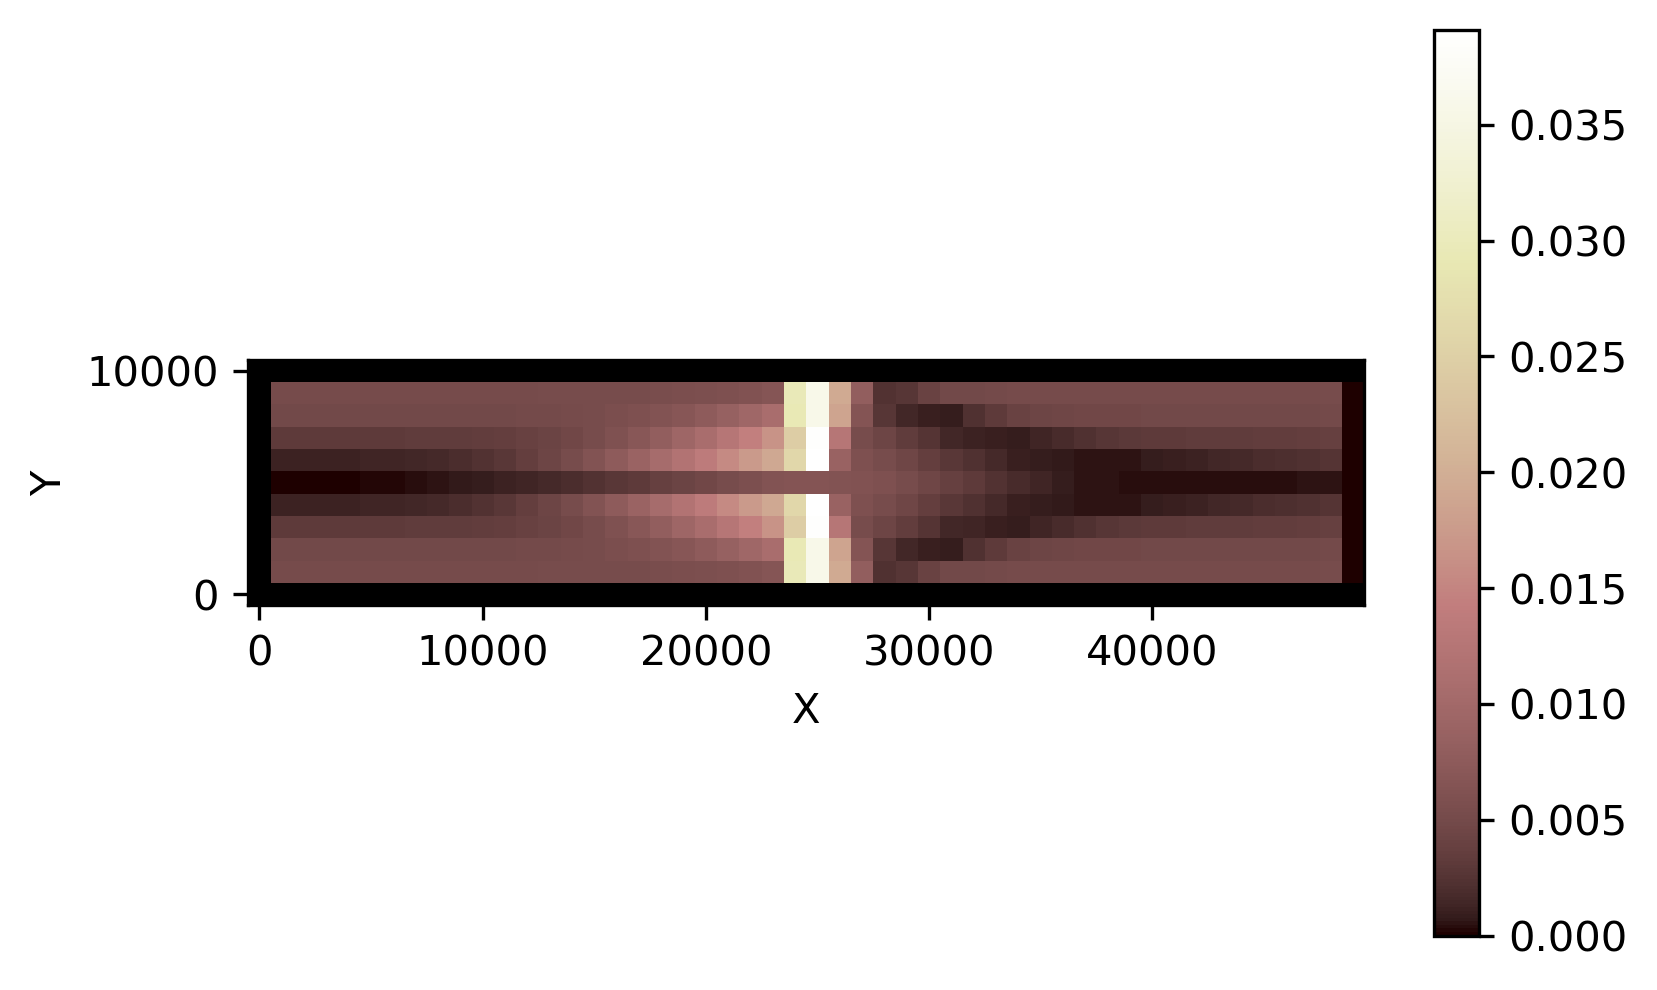

In [32]:
imshow_grid(grid, transporter._slope)

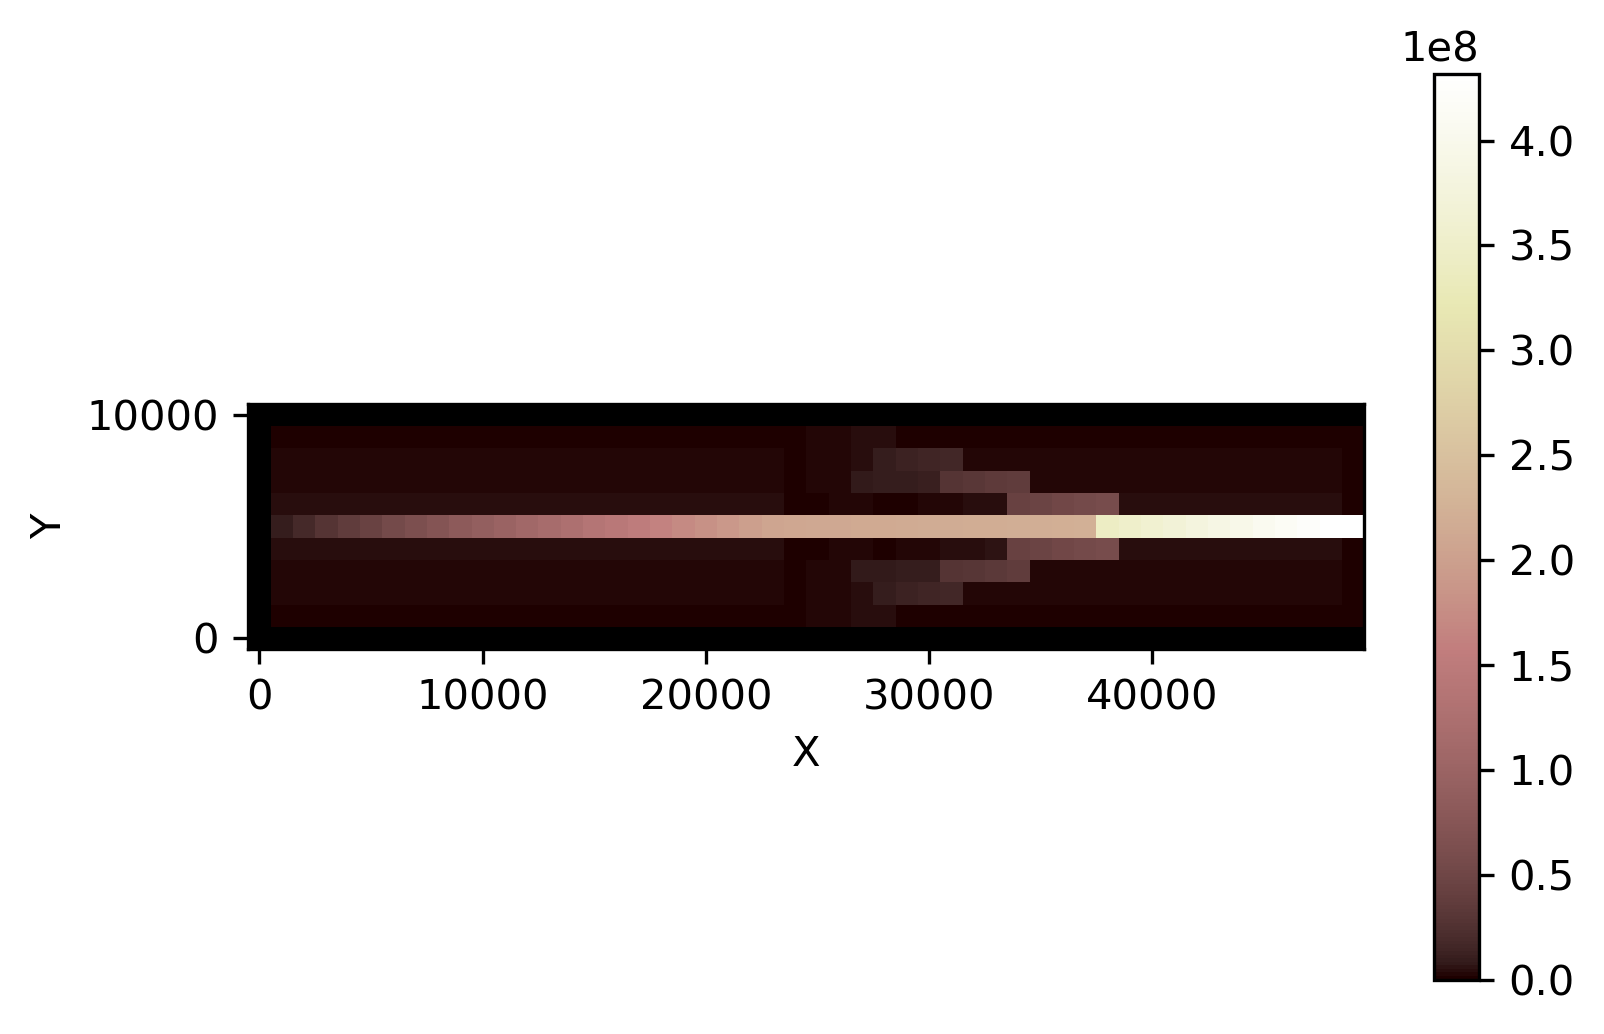

In [33]:
imshow_grid(grid, grid.at_node["drainage_area"])

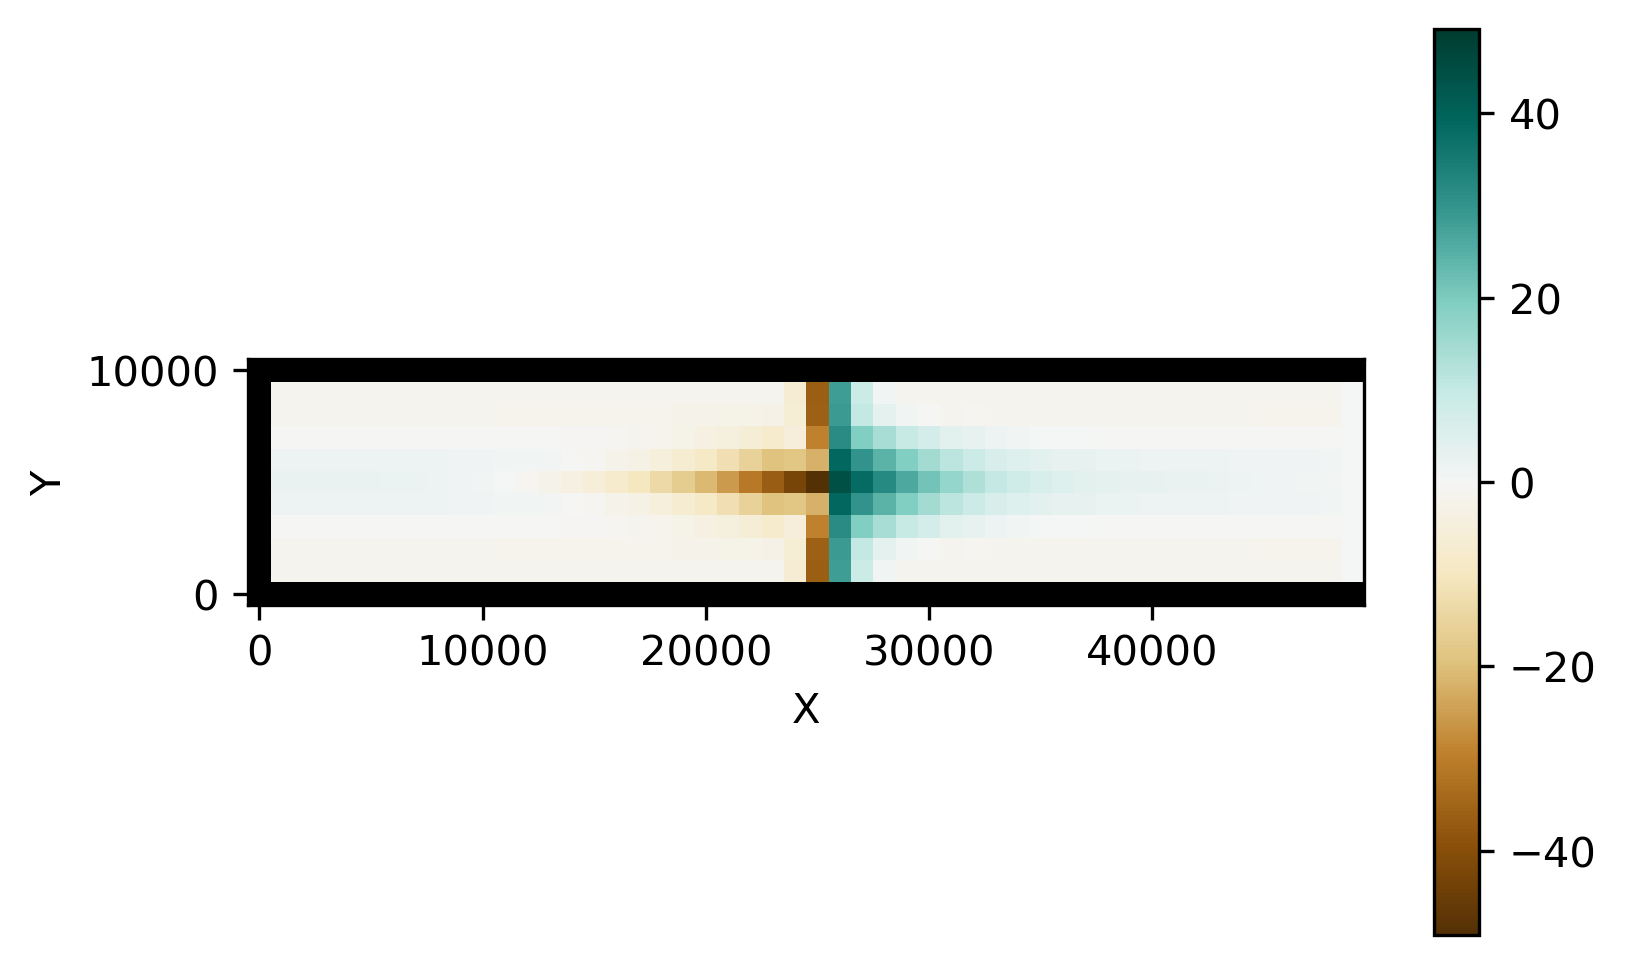

In [34]:
dz = elev - init_elev
cr = np.amax(np.abs(dz))
imshow_grid(grid, dz, cmap='BrBG', vmin=-cr, vmax=cr)

In [35]:
np.sum(grid.at_node["drainage_area"][grid.status_at_node==grid.BC_NODE_IS_FIXED_VALUE]) / (dx*dx)

432.0

#### Explicit time-step limits

This is a quasi-diffusive problem with a flux proportional to $k_Q I Q$. Suppose the maximum discharge is runoff rate times domain area. Then the CFL would seem to be:

$$\Delta t \lt \frac{\Delta x^2}{2 k_Q I r a_d}$$

where $a_d$ is domain area. Here's a calculation for this domain:

In [36]:
dtmax = 1.0 / (2 * 0.041 * 0.01 * 10.0 * nrows * ncols)
print(dtmax)

0.22172949002217296


This tiny value implies the need for better solvers!

In [37]:
# Continue loop
for _ in range(nsteps):
    fa.run_one_step()
    transporter.run_one_step(dt)

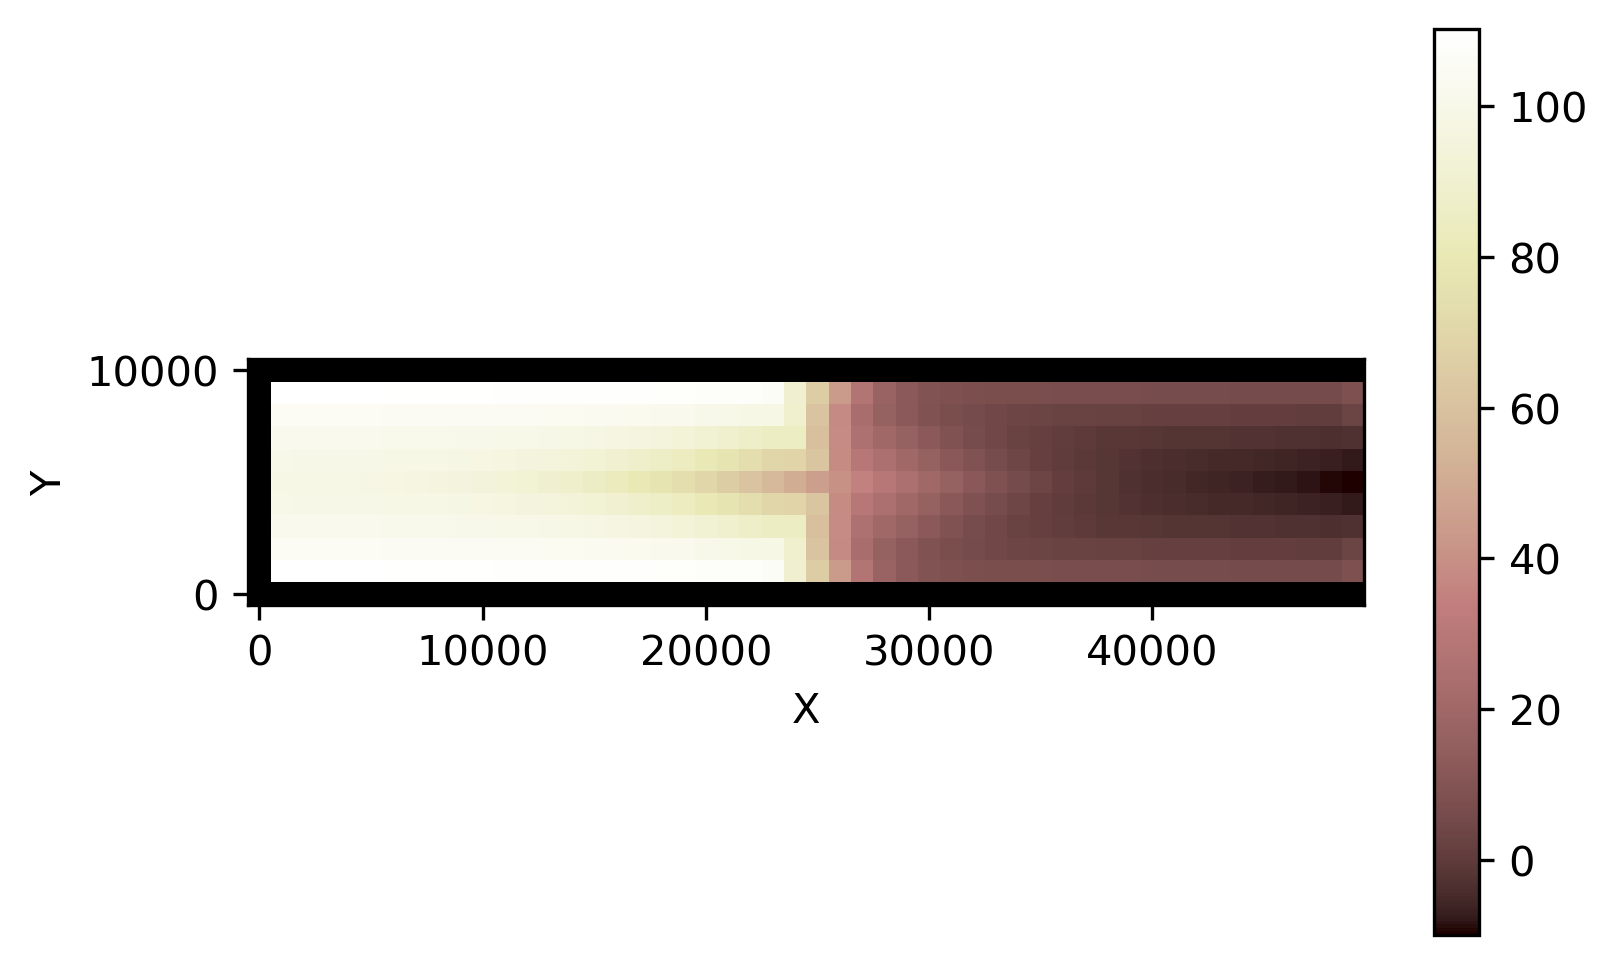

In [38]:
imshow_grid(grid, elev)

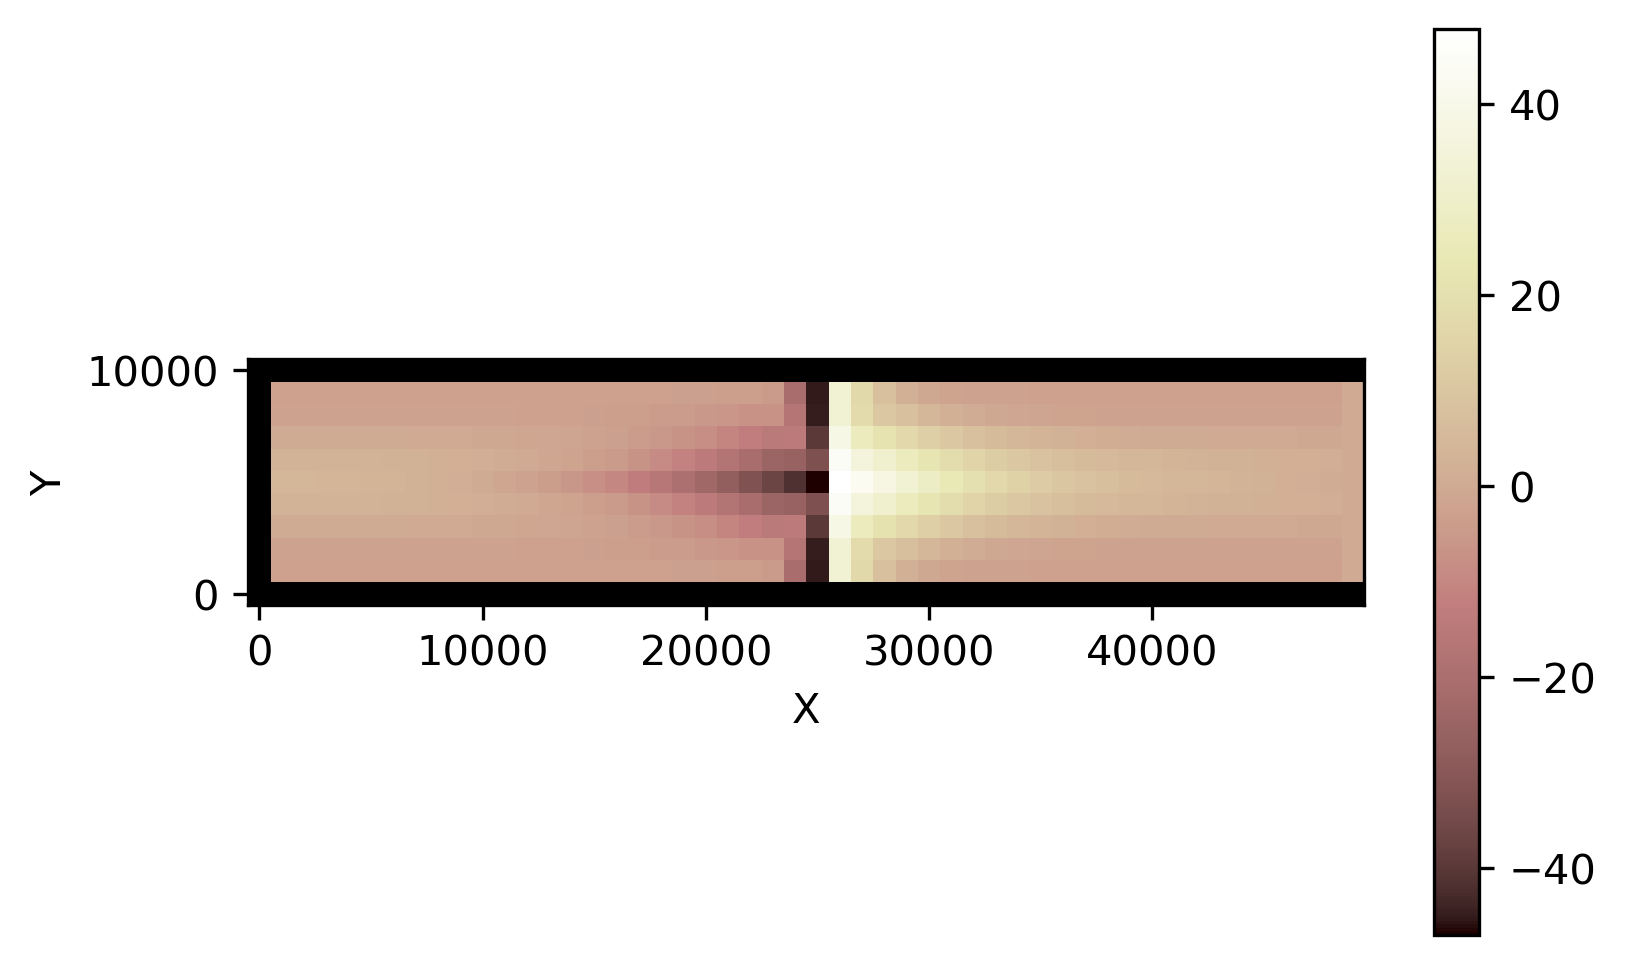

In [39]:
imshow_grid(grid, elev - init_elev)

In [40]:
# Continue loop
for _ in range(nsteps):
    fa.run_one_step()
    transporter.run_one_step(dt)

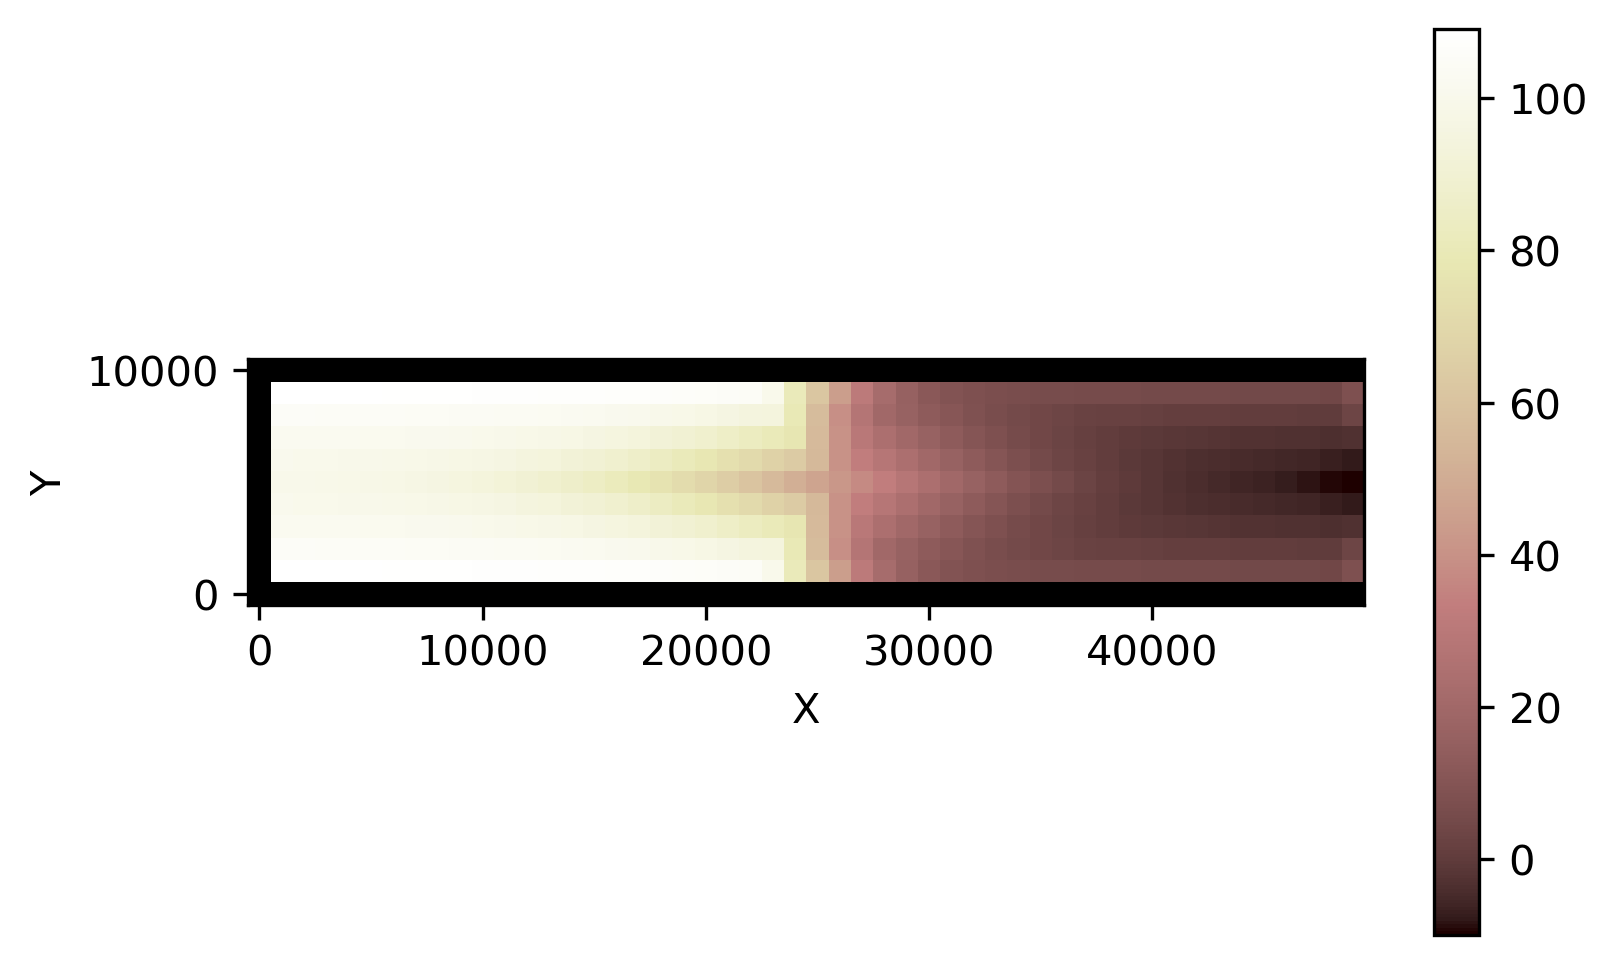

In [41]:
imshow_grid(grid, elev)

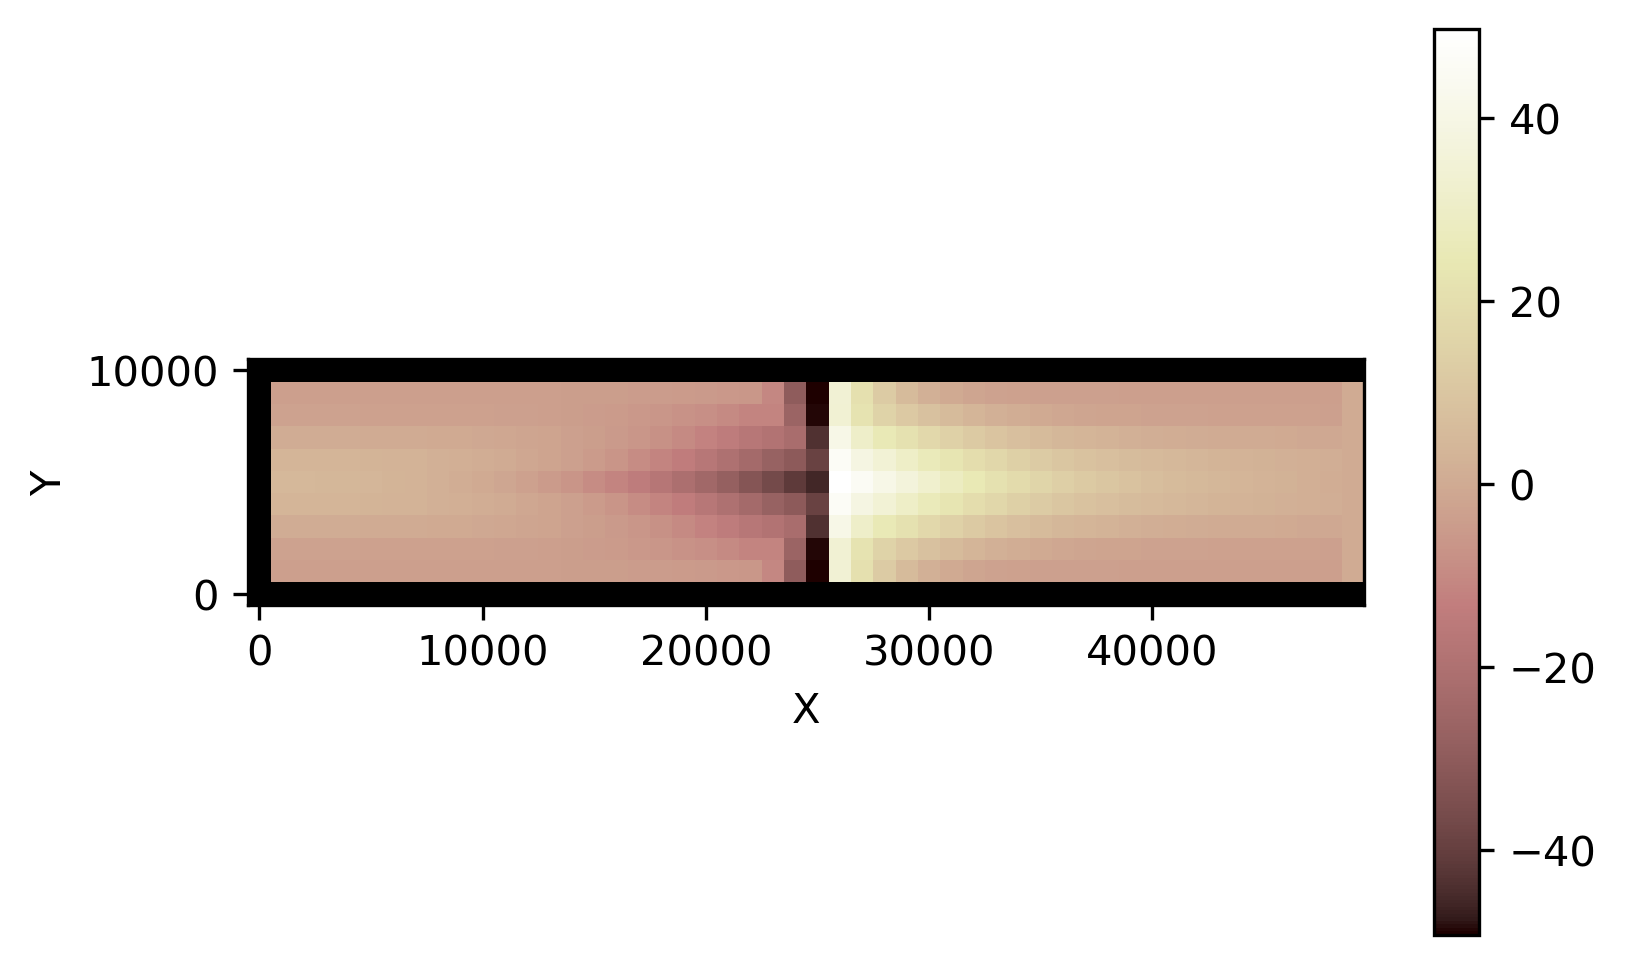

In [42]:
imshow_grid(grid, elev - init_elev)

In [43]:
# Continue loop
for _ in range(nsteps):
    fa.run_one_step()
    transporter.run_one_step(dt)

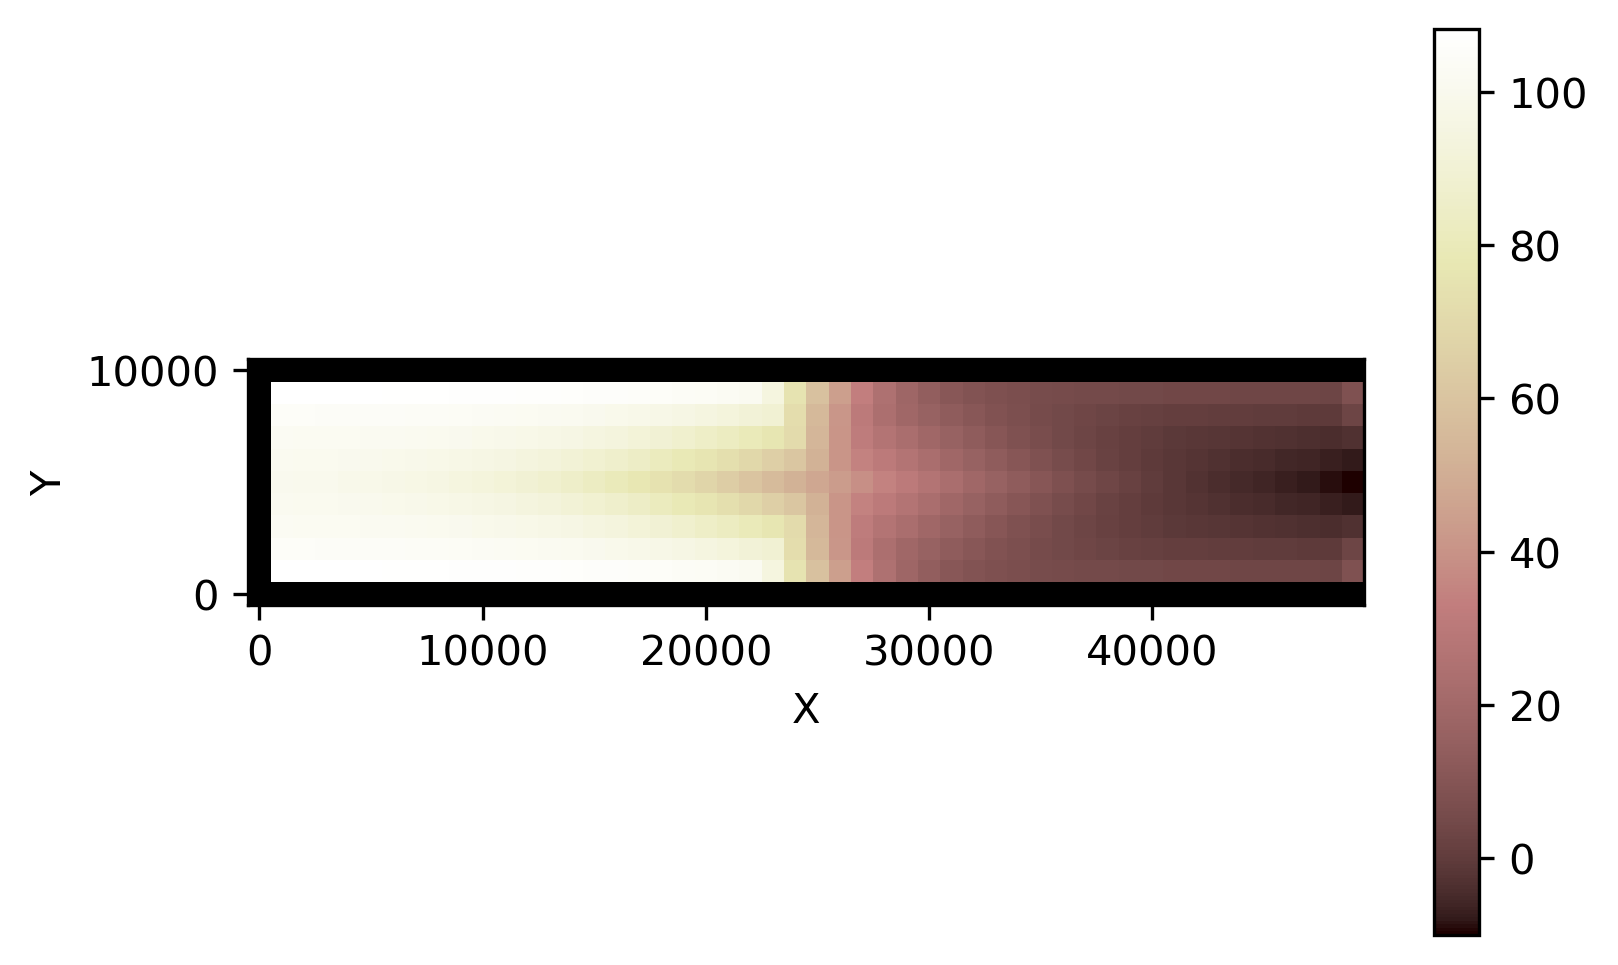

In [44]:
imshow_grid(grid, elev)

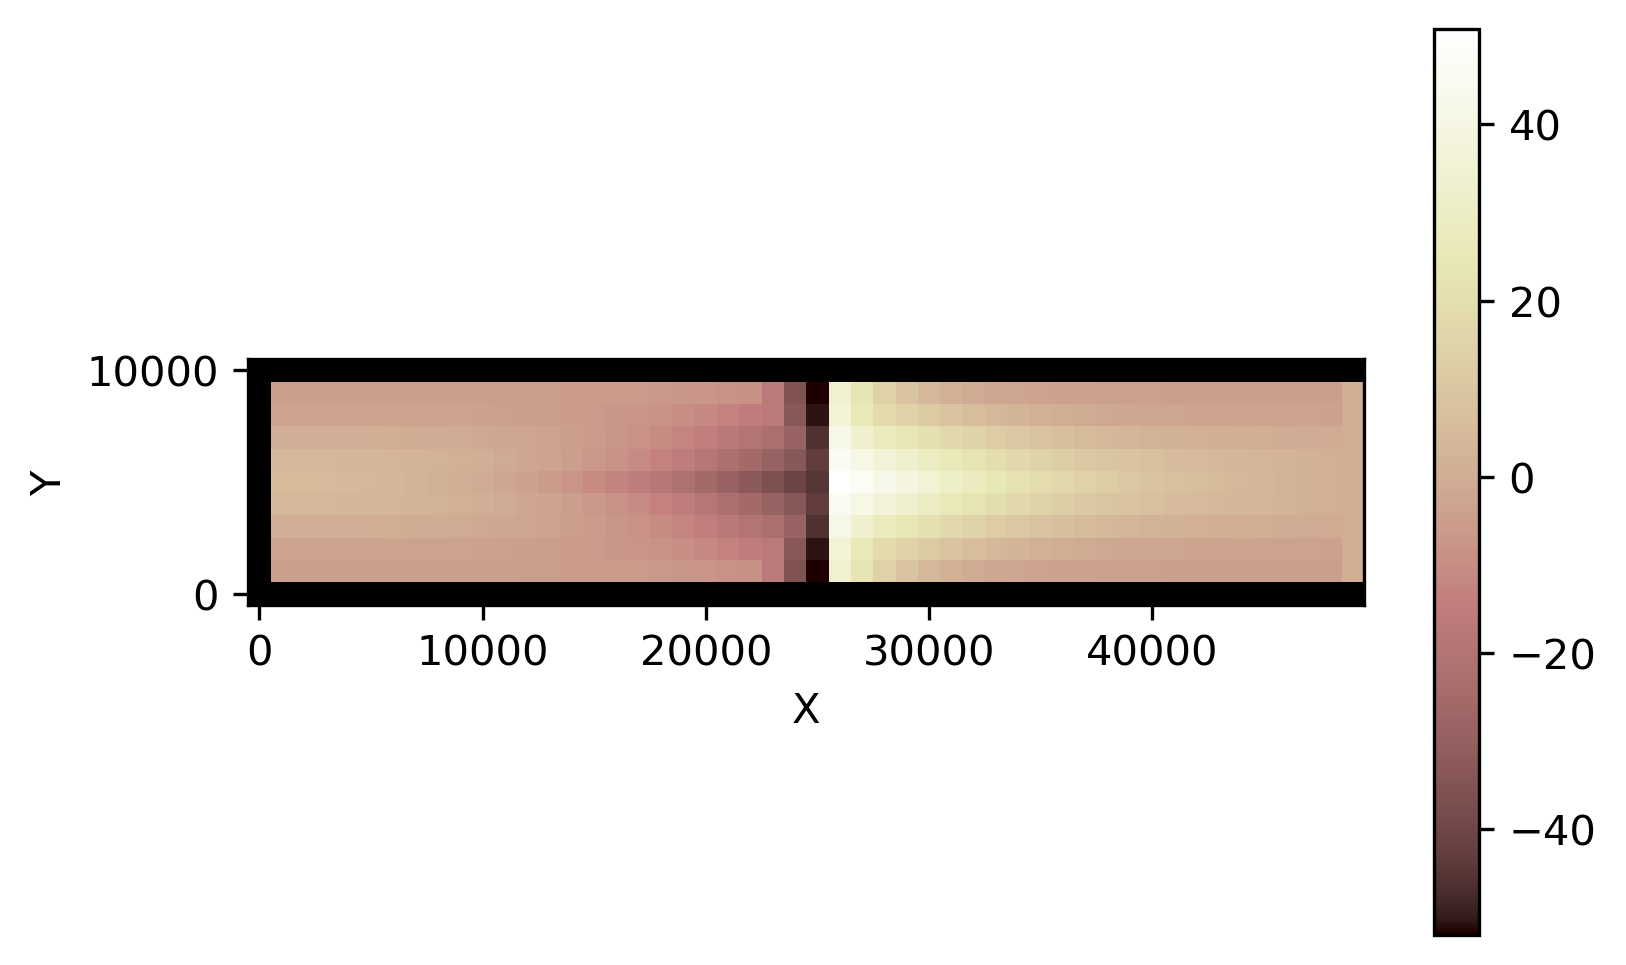

In [45]:
imshow_grid(grid, elev - init_elev)

## Potential matrix solution

Here we test out a little algorithm to create, populate, and invert a matrix.

In [46]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from landlab.utils.matrix import get_core_node_at_node


def make_empty_matrix_and_rhs(grid):
    mat = csc_matrix(
        (grid.number_of_core_nodes, grid.number_of_core_nodes),
    )
    rhs = np.zeros(grid.number_of_core_nodes)
    return mat, rhs


# make a tiny (3 core node) test grid
matgrid = RasterModelGrid((3, 5))
matgrid.status_at_node[matgrid.nodes_at_top_edge] = matgrid.BC_NODE_IS_CLOSED
matgrid.status_at_node[matgrid.nodes_at_left_edge] = matgrid.BC_NODE_IS_CLOSED
melev = matgrid.add_zeros("topographic__elevation", at="node")

# lookup table to convert node ID to matrix (same as core) ID
matrix_id = get_core_node_at_node(matgrid)

# set the "f" (surrogate for discharge and slope to 1/6)
f = np.zeros(matgrid.number_of_nodes)
f[6:9] = [1, 2, 3]

# make up receivers
rcvr = np.arange(matgrid.number_of_nodes, dtype=int)
rcvr[6:9] += 1  # point downstream to the right

# set the a and b coefficients (just made up here)
a = 1.0
b = 0.5

# create the matrix and rhs
mat, rhs = make_empty_matrix_and_rhs(matgrid)

def zero_out_matrix(matgrid, mat, rcvr, matid):
    for i in matgrid.core_nodes:
        j = matid[i]
        mat[j,j] = 0.0
        r = rcvr[i]
        if matgrid.status_at_node[r] == matgrid.BC_NODE_IS_CORE:
            k = matid[r]
            mat[j,k] = 0.0
            mat[k,k] = 0.0
            mat[k,j] = 0.0

# algorithm to fill out the matrix entries
def fill_matrix_and_rhs(matgrid, mat, rhs, zvals, fvals, rcvr, matid, a, b):
    zero_out_matrix(matgrid, mat, rcvr, matid)
    for i in matgrid.core_nodes:
        j = matid[i]
        rhs[j] = zvals[i]
        mat[j,j] += 1 + a * fvals[i]
        r = rcvr[i]
        if matgrid.status_at_node[r] == matgrid.BC_NODE_IS_CORE:
            k = matid[r]
            mat[j,k] -= a * fvals[i]
            mat[k,k] += b * fvals[i]
            mat[k,j] -= b * fvals[i]
        else:
            rhs[j] += a * fvals[i] * zvals[r]
    return mat, rhs

In [47]:
mat, rhs = fill_matrix_and_rhs(matgrid, mat, rhs, melev, f, rcvr, matrix_id, a, b)

/Users/gtucker/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [48]:
# Predicted mat:
pred = np.array([[ 1 + a * f[6], -a * f[6] ,  0],
                 [-b * f[6], 1 + a * f[7] + b * f[6], -a * f[7]],
                 [ 0, -b * f[7], 1 + a * f[8] + b * f[7] ],
])

print(pred)
print(mat)

[[ 2.  -1.   0. ]
 [-0.5  3.5 -2. ]
 [ 0.  -1.   5. ]]
  (0, 0)	2.0
  (1, 0)	-0.5
  (0, 1)	-1.0
  (1, 1)	3.5
  (2, 1)	-1.0
  (1, 2)	-2.0
  (2, 2)	5.0


In [49]:
# rhs should be all zeros
print(rhs)

[ 0.  0.  0.]


Now try with semi-realistic values. We'll use a runoff rate of 10, kQ of 0.041, I of 0.01, and dt of 1 year.

In [50]:
kQ = 0.041
I = 0.01
dt = 1000.0
dx = 1.0
beta = 1.0 / 5000.0
pfac = 1.0 / (1.0 - 0.35)  # porosity factor
U = 0.001
a = (pfac * kQ * I * dt / dx**2) * ((1 / dx) + 0.5 * beta)
b = (pfac * kQ * I * dt / dx**2) * ((1 / dx) - 0.5 * beta)
f = np.zeros(matgrid.number_of_nodes)
f[6] = 10.0
f[7] = 20.0
f[8] = 30.0

In [51]:
mat, rhs = fill_matrix_and_rhs(matgrid, mat, rhs, melev, f, rcvr, matrix_id, a, b)
rhs[:] += U * dt
print(mat)
print(rhs)

  (0, 0)	7.30832307692
  (1, 0)	-6.30706153846
  (0, 1)	-6.30832307692
  (1, 1)	19.9237076923
  (2, 1)	-12.6141230769
  (1, 2)	-12.6166461538
  (2, 2)	32.5390923077
[ 1.  1.  1.]


In [52]:
for i in range(10):
    mat, rhs = fill_matrix_and_rhs(matgrid, mat, rhs, melev, f, rcvr, matrix_id, a, b)
    rhs[:] += U * dt
    melev[matgrid.core_nodes] = spsolve(mat, rhs)
    print(melev[6:9])
print(-np.diff(melev[6:9]))

[ 0.33944098  0.23472869  0.12172732]
[ 0.43763589  0.29468108  0.14870946]
[ 0.46503906  0.3108623   0.1558115 ]
[ 0.47262203  0.31530336  0.15775139]
[ 0.4747162   0.31652744  0.15828553]
[ 0.47529427  0.31686518  0.15843287]
[ 0.47545383  0.31695839  0.15847353]
[ 0.47549786  0.31698411  0.15848476]
[ 0.47551002  0.31699121  0.15848785]
[ 0.47551337  0.31699317  0.15848871]
[ 0.1585202   0.15850446]


In [53]:
# Check: is this consistent with predicted slope, given negligible abrasion?
Supper = U * dx * dx / (pfac * kQ * I * 10.0)
print(Supper)

0.15853658536585366


Try now with the nonlinear portion of slope, using the prior value as an approximation
(which will presumably limit stability a bit).

In [54]:
Q = np.zeros(matgrid.number_of_nodes)
Q[6] = 10.0
Q[7] = 20.0
Q[8] = 30.0

melev[:] = 0.0  # reset elevations

slope = np.zeros(matgrid.number_of_nodes)

In [55]:
for i in range(10):
    slope[matgrid.core_nodes] = (melev[matgrid.core_nodes] - melev[rcvr[matgrid.core_nodes]]) / dx
    f[matgrid.core_nodes] = Q[matgrid.core_nodes] * slope[matgrid.core_nodes]**(1./6.)
    print("f:", f[matgrid.core_nodes])
    mat, rhs = fill_matrix_and_rhs(matgrid, mat, rhs, melev, f, rcvr, matrix_id, a, b)
    rhs[:] += U * dt
    melev[matgrid.core_nodes] = spsolve(mat, rhs)
    print(melev[6:9])
print(-np.diff(melev[6:9]))

f: [ 0.  0.  0.]
[ 1.  1.  1.]
f: [  0.   0.  30.]
[ 2.          2.          0.10037657]
f: [  0.          22.25740775  20.45156958]
[ 3.          0.4448972   0.26291879]
f: [ 11.69233894  15.05566607  24.01180781]
[ 1.08633055  0.69130521  0.30524152]
f: [  8.56585712  17.06631756  24.61662572]
[ 0.72598015  0.47423214  0.23485306]
f: [  7.94622771  15.75956989  23.56426836]
[ 0.64259425  0.42646764  0.21212348]
f: [  7.74672324  15.47207654  23.16786674]
[ 0.62393926  0.4154925   0.20756555]
f: [  7.70015012  15.39389284  23.08414531]
[ 0.61981297  0.41309643  0.20649271]
f: [  7.68946049  15.3775219   23.06421656]
[ 0.61890446  0.41256391  0.20626398]
f: [  7.68712772  15.37375099  23.05995674]
[ 0.61870434  0.41244726  0.20621263]
[ 0.20625709  0.20623462]


That seems to work reasonably smoothly. Now, how about the analytical solution? 

In [56]:
# Check: is this consistent with predicted slope, given negligible abrasion?
Supper_nl = (U * dx * dx / (pfac * kQ * I * 10.0))**(6./7.)
print(Supper_nl)

0.2062513093249767


Hey, that actually worked!

#### Try with a slightly more complex grid, like:

```
o o o o

o . .-o
   \
o .-.-o

o o o o
```



In [57]:
matgrid2x2 = RasterModelGrid((4, 4))
melev2x2 = matgrid2x2.add_zeros("topographic__elevation", at="node")

rcvr = np.arange(matgrid2x2.number_of_nodes, dtype=int)
rcvr[5] = 6
rcvr[6] = 7
rcvr[9] = 6  # convergence of 2 tribs
rcvr[10] = 11

Q = np.zeros(matgrid2x2.number_of_nodes)
Q[5] = 10.0
Q[6] = 30.0  # convergence of 2 tribs
Q[9] = 10.0
Q[10] = 10.0

slope = np.zeros(matgrid2x2.number_of_nodes)
f = np.zeros(matgrid2x2.number_of_nodes)

In [58]:
# create the matrix and rhs
mat2x2, rhs2x2 = make_empty_matrix_and_rhs(matgrid2x2)

# lookup table to convert node ID to matrix (same as core) ID
matrix_id2x2 = get_core_node_at_node(matgrid2x2)

for i in range(8):
    slope[matgrid2x2.core_nodes] = (melev2x2[matgrid2x2.core_nodes] - melev2x2[rcvr[matgrid2x2.core_nodes]]) / dx
    f[matgrid2x2.core_nodes] = Q[matgrid2x2.core_nodes] * slope[matgrid2x2.core_nodes]**(1./6.)
    print("f:", f[matgrid2x2.core_nodes])
    mat, rhs = fill_matrix_and_rhs(matgrid2x2, mat2x2, rhs2x2, melev2x2, f, rcvr, matrix_id2x2, a, b)
    rhs[:] += U * dt
    melev2x2[matgrid2x2.core_nodes] = spsolve(mat2x2, rhs2x2)
    print(melev2x2[6:9])
print(slope[matgrid2x2.core_nodes])

f: [ 0.  0.  0.  0.]
[ 1.  0.  0.]
f: [  0.  30.   0.  10.]
[ 0.10037657  0.          0.        ]
f: [ 11.12870388  20.45156958  11.12870388   8.05753207]
[ 0.40578278  0.          0.        ]
f: [  8.28518492  25.81290346   8.28518492   7.70589746]
[ 0.2272029  0.         0.       ]
f: [  7.88990772  23.43456516   7.88990772   7.68712074]
[ 0.21046329  0.          0.        ]
f: [  7.7125021   23.13754706   7.7125021    7.6864853 ]
[ 0.2067462  0.         0.       ]
f: [  7.69128232  23.06893323   7.69128232   7.68646443]
[ 0.20630471  0.          0.        ]
f: [  7.68709151  23.06071553   7.68709151   7.68646375]
[ 0.20622271  0.          0.        ]
[ 0.20633472  0.20630471  0.20633472  0.20623364]


Conclusion: the solution overshoots, due to the zero-initial-slope problem, but otherwise it seems to work fine.

In [59]:
mat2x2.toarray()

array([[  5.84926568,  -4.84926568,   0.        ,   0.        ],
       [ -4.84829592,  25.24403624,  -4.84829592,   0.        ],
       [  0.        ,  -4.84926568,   5.84926568,   0.        ],
       [  0.        ,   0.        ,   0.        ,   5.84886966]])

In [60]:
tm = csc_matrix((2, 2))
tm.toarray()

array([[ 0.,  0.],
       [ 0.,  0.]])

In [61]:
0.01**(7./6)

0.004641588833612777

In [62]:
0.004641588833612777*10000*4.1e-7

1.9030514217812386e-05

In [63]:
a=0.041*0.01*1000.0 / (100 * 100 * 100)
f1 = 100 * 100 * (0.01)**(1./6.)
f2 = 200 * 100 * (0.01)**(1./6.)
print(a, f1, f2)
print(1+a*f1)
print(-a*f1)
print(1+a*f1+a*f2)

4.1000000000000004e-07 4641.588833612779 9283.177667225558
1.0019030514217813
-0.0019030514217812397
1.0057091542653438


In [64]:
mat = csc_matrix((2, 2))
mat[0,0] = 1.0057091542653438
mat[0,1] = -0.0019030514217812397
mat[1,0] = -0.0019030514217812397
mat[1,1] = 1.0019030514217813
rhs = np.array([1.0, 2.0])

print(spsolve(mat, rhs))

[ 0.99810415  1.99809696]


In [65]:
class frog():
    def __init__(self):
        self.two = self.one

    def one(self):
        print('i am one')

toad = frog()

toad.one()
toad.two()

toad.one == toad.two

i am one
i am one


True

In [66]:
mat = csc_matrix((2, 2))
mat[0,0] = 1.0057
mat[0,1] = -0.0019
mat[1,0] = -0.0019
mat[1,1] = 1.0019

rhs = np.array([1., 2.])

print(spsolve(mat, rhs))

[ 0.99810718  1.99810001]


In [67]:
50*2500/25000

5.0